# Udacity Nanodegree capstone

## Product - Thailand SET stock predictor 

Udacity Nanodegree capstone project creating a Thailand stock predictor.
Project is divided in to 3 main notebooks:
1. Data exploration/visualisation/preparation
2. Data training/modelling/optimisation
3. Data review/prediction

Project involves testing with various inputs including:
- Thailand Stock price data
- Google trends interest information
- Covid19 statistics results

Output of this project is a Jupyter notebook with code that create/train/test model to predict SET Thailand stock prices. 

Features engineered:
- Stock open, high, low, close, volume
- Stock MA (moving average)
- Stock EMA (exponentail moving average)
- Stock RSI (relative strength index)
- Foreign SET trade details
- Similar stock ohlc, volume, MA, EMA, RSI by related industry
- Similar stock close price by correlation analysis (within SET100 stocks)
- SET50, SET100 index
- Google trends interest data with keywords [stock symbol, sector name, industry name, top 2 relates queries]
- Covid19 Thailand statistics results

Data processing:
- Granger causality testing - determining whether a lag price on one have an affect on another
- MinMaxScaled data to process
- Inverse scaled data for predicted output
- Train-test dataset for testing and evaluating model performance
- Train-predict dataset for predicting future data

Modelling:
- Linear regression
- Random forest regressor
- Support Vector Maching (SVM) - LinearSVR
- Support Vector Maching (SVM) - SVR (polynomial)
- Gradient boosting regression
- Facebook prophet

Optimisation:
- Manual parameter tuning
- RandomSearch parameter optimisation
- Facebook prophet add regressor optimisation
- Ensemble model optimisation (selective average from models)

Prediction:
- Review final model
- Predict stock closing price based on stocks which have granger causality lag

For further information, please refer to xxxxxxxx repo with the report and setup instructions.


## DRAFT NOTEBOOK
Initial draft of the notebook data for this project.


#### Install needed libraries
note -> check the project readme files for requirements

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# import nltk
# nltk.download(['punkt', 'wordnet'])
# nltk.download('words')
# nltk.download('vader_lexicon')

# from nltk import sent_tokenize
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# SVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import sqlalchemy as db

import pickle
import time
import joblib
import requests

import datetime

import starfishX as sx
from pytrends.request import TrendReq
import pandas_ta as pta
from tqdm.notebook import tqdm 
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from prophet import Prophet

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import mplfinance as mpf

matplotlib.rc('font', family='Ayuthaya')
%matplotlib inline


# Data exploration

1. Exploring thee data from different sources, and seeing which is relevant and is going to be used.
2. Data clean up and feature engineering

Sources
- SET Thailand stock data
- Google trends data
- Covid19 Thailand stats

### SET stock information - starfishX
- Stock info price, high, low, open, close
- Stock balance sheet statement and date period as graph? and then regression for trend and growth?
- financial ration and margins factors

Move this to first section for getting the stock information

output
- the functions for data
- visualised plots on data showcase

In [2]:
def create_set_sector_industry_file(set_sector_filename = '20210820_set_stock_industry'):
    '''
    Creating the SET sector and industry and file as csv
    Data to fetch takes a lot of time so easier to save locally for usage
    By updating this, we can get and use the latest stock information if there are name changes etc
    
    Note
    - Should look to rerun this if there are process issues
    
    Input:
    - Name of file
    
    Process:
    - Fetch the latest SET stock data information
    - Create the SET stock stock and industry csv file if it does not exist
    
    Output:
    - SET stock information with stock sector and industry
    '''
    
    set_sector_csv = Path('./' + set_sector_filename + '.csv')
    if set_sector_csv.is_file():
        print('File already exist....')
    else:
        df_all_stock = sx.listSecurities(industry=True) # Getting name and market
        df_all_stock.to_csv(set_sector_filename +'.csv')
        print('File does not exist....created new csv file')
    
    df_all_stock = pd.read_csv(set_sector_csv)
    
    return df_all_stock


In [3]:
def is_stock_in_SET(stock_symbol = 'DELTA', showSectorIndustry = False, showLog = True):

    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # -> Update to use sx.listSecurities() to check with latest ones   
    # Read the stock name data for testing validity and extracting sector information
    df_stock_sector = pd.read_csv('20210820_set_stock_industry.csv')

    # Check whether it is in SET or not otherwise reject    
    if not df_stock_sector['symbol'].str.contains(stock_symbol).any():
        if showLog:
            print('Symbol not part of SET or is not supported. Please try input again')
        return False
    else:
        if showSectorIndustry:
            if showLog:
                print('Returning sector industry info of : ', stock_symbol)
            return df_stock_sector[df_stock_sector.symbol == stock_symbol]['industry'].str.split('/',expand=True).rename(columns={0: "sector", 1: "industry"})
        else :
            if showLog:
                print(stock_symbol,': is part of SET stock')
            return True

In [4]:
def get_SET_stock_sector_industry():
    ''' 
    Get list of all stocks in industry with sector and industry info.
    This is based on sx.listSecurities() function that gets the latest data and we store this information in csv
    file for performance purposes.
    
    Output:
    - Dataframe with list of stocks and sector and industry
    
    '''
    
    # Read the stock name data for testing validity and extracting sector information
    df_stock_sector = pd.read_csv('20210820_set_stock_industry.csv')
    temp_df = df_stock_sector['industry'].str.split('/',expand=True).rename(columns={0: "sector", 1: "industry"})
    df_stock_sector['sector'] = temp_df['sector']
    df_stock_sector['industry'] = temp_df['industry']
    
    return df_stock_sector

In [5]:
def get_set_stock_hist_price(stock_symbol = 'DELTA', start_date = '2020-01-01', ohlc=True, volume=True):
    '''
    Function to get the stock data to be ready for processing and analysis.
    Return data in daily date with high and low results in dataframe format

    Input:
    - stock_symbol - stock symbol in caps
    - start_date (format yyyy-mm-dd)
    - ohlc (OPEN, HIGH, LOW, CLOSE) data flag
    - volume (stock traded volume) data flag
    
    Output:
    - Stock information and price overtime, volumn, total traded price

    '''
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Check if the input is not in SET list then return 0
#     if not is_stock_in_SET(stock_symbol):
#         print('Stock symbol: ', stock_symbol, ': Is not found. Please try again.')
#         return 0
    
    # Load the historical data from starfishX library regarding the stock price information
    df_stock = sx.loadHistData(stock_symbol,start=start_date,OHLC=ohlc, Volume=volume)
    
    return df_stock

In [6]:
def cal_stock_ema(stock_symbol='DELTA', start_date='2020-01-01'):
    '''
    Calculate the stock EMA data overtime for the different set periods (Exponential moving average)
    
    Input:
    - stock_symbol
    - start_date
    
    Output:
    - Dataframe with the stock price, and EMA with different periods (10, 30, 50)
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Fetch stock closing price for the stock symbol
    df_stock_data = get_set_stock_hist_price(stock_symbol,'2020-01-01')['CLOSE']
        
    # Create dataframe for the finalised output EMA data from stock
    ema_data = pd.concat([
                        df_stock_data.rename(stock_symbol + '_close_price')
                        ,df_stock_data.ewm(span=10,adjust=False).mean().rename(stock_symbol + '_ema10')
                        ,df_stock_data.ewm(span=30,adjust=False).mean().rename(stock_symbol + '_ema30')
                        ,df_stock_data.ewm(span=50,adjust=False).mean().rename(stock_symbol + '_ema50')
                    ],axis=1)
    
    return ema_data

In [7]:
def stock_ema_exploration(stock_symbol = 'DELTA'):
    '''
    Stock EMA (Exponential Moving Average) exploration and visualisation.
    Exploration with various periods and values for showcase
    
    Input:
    - stock_symbol
    
    Output:
    - Visualisation of different EMA period values
    
    Note:
    - Based on this results, we recommend to use 10, 30, 50 as base standards for prediction in our case
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Fetch stock closing price for the stock symbol
    df_stock_data = get_set_stock_hist_price(stock_symbol,'2020-01-01')['CLOSE']
    
    # Generate the EMA for different periods
    ema_data = pd.concat([
                        df_stock_data.rename('close_price')
                        ,df_stock_data.ewm(span=5,adjust=False).mean().rename('ema5')
                        ,df_stock_data.ewm(span=10,adjust=False).mean().rename('ema10')
                        ,df_stock_data.ewm(span=20,adjust=False).mean().rename('ema20')
                        ,df_stock_data.ewm(span=30,adjust=False).mean().rename('ema30')
                        ,df_stock_data.ewm(span=40,adjust=False).mean().rename('ema40')
                        ,df_stock_data.ewm(span=50,adjust=False).mean().rename('ema50')
                        ,df_stock_data.ewm(span=100,adjust=False).mean().rename('ema100')
                        ,df_stock_data.ewm(span=200,adjust=False).mean().rename('ema200')
                    ],axis=1)
    
    # EMA data plot for different time periods with the stock closing price
    plt.figure(figsize=(14,10))
    sns.lineplot(data = ema_data,x=ema_data.index,y='close_price')
    sns.lineplot(data = ema_data,x=ema_data.index,y='ema5')
    sns.lineplot(data = ema_data,x=ema_data.index,y='ema10')
    sns.lineplot(data = ema_data,x=ema_data.index,y='ema20')
    sns.lineplot(data = ema_data,x=ema_data.index,y='ema30')
    sns.lineplot(data = ema_data,x=ema_data.index,y='ema40')
    sns.lineplot(data = ema_data,x=ema_data.index,y='ema50')
    sns.lineplot(data = ema_data,x=ema_data.index,y='ema100')
    sns.lineplot(data = ema_data,x=ema_data.index,y='ema200')
    
    labels_list = ema_data.columns
    plt.legend(labels=labels_list)
    plt.show()

In [8]:
def cal_stock_ma(stock_symbol='DELTA', start_date='2020-01-01'):
    '''
    Calculate the stock MA data overtime for the different set periods (Moving average)
    
    Input:
    - stock_symbol
    - start_date
    
    Output:
    - Dataframe with the stock price, and MA with different periods (10, 30, 50, 100)
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Fetch stock closing price for the stock symbol
    df_stock_data = get_set_stock_hist_price(stock_symbol,'2020-01-01')['CLOSE']
        
    # Create dataframe for the finalised output MA data from stock
    ma_data = pd.concat([
                        df_stock_data.rename(stock_symbol + '_close_price')
                        ,df_stock_data.rolling(10).mean().rename(stock_symbol + '_ma10')
                        ,df_stock_data.rolling(30).mean().rename(stock_symbol + '_ma30')
                        ,df_stock_data.rolling(50).mean().rename(stock_symbol + '_ma50')
                        ,df_stock_data.rolling(100).mean().rename(stock_symbol + '_ma100')
                    ],axis=1)
    
    return ma_data

In [9]:
def stock_ma_exploration(stock_symbol = 'DELTA'):
    '''
    Stock MA (Moving Average) exploration and visualisation.
    Exploration with various periods and values for showcase
    
    Input:
    - stock_symbol
    
    Output:
    - Visualisation of different MA period values
    
    Note:
    - Based on this results, we recommend to use 10, 30, 50, 100 as base standards for prediction in our case
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Fetch stock closing price for the stock symbol
    df_stock_data = get_set_stock_hist_price(stock_symbol,'2020-01-01')['CLOSE']
    
    # Generate the MA for different periods
    ma_data = pd.concat([
                        df_stock_data.rename('close_price')
                        ,df_stock_data.rolling(5).mean().rename('ma5')
                        ,df_stock_data.rolling(10).mean().rename('ma10')
                        ,df_stock_data.rolling(20).mean().rename('ma20')
                        ,df_stock_data.rolling(30).mean().rename('ma30')
                        ,df_stock_data.rolling(40).mean().rename('ma40')
                        ,df_stock_data.rolling(50).mean().rename('ma50')
                        ,df_stock_data.rolling(100).mean().rename('ma100')
                        ,df_stock_data.rolling(200).mean().rename('ma200')
                    ],axis=1)
    
    # MA data plot for different time periods with the stock closing price
    plt.figure(figsize=(14,10))
    sns.lineplot(data = ma_data,x=ma_data.index,y='close_price')
    sns.lineplot(data = ma_data,x=ma_data.index,y='ma5')
    sns.lineplot(data = ma_data,x=ma_data.index,y='ma10')
    sns.lineplot(data = ma_data,x=ma_data.index,y='ma20')
    sns.lineplot(data = ma_data,x=ma_data.index,y='ma30')
    sns.lineplot(data = ma_data,x=ma_data.index,y='ma40')
    sns.lineplot(data = ma_data,x=ma_data.index,y='ma50')
    sns.lineplot(data = ma_data,x=ma_data.index,y='ma100')
    sns.lineplot(data = ma_data,x=ma_data.index,y='ma200')
    
    labels_list = ma_data.columns
    plt.legend(labels=labels_list)
    plt.show()

In [10]:
def cal_stock_rsi(stock_symbol='DELTA', start_date='2020-01-01'):
    '''
    Calculate the stock RSI data overtime for the different set periods (Relative Strength Index)
    
    Input:
    - stock_symbol
    - start_date
    
    Output:
    - Dataframe with the stock price, and RSI with different periods (2, 6, 14, 30)
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Fetch stock closing price for the stock symbol
    df_stock_data = get_set_stock_hist_price(stock_symbol,'2020-01-01')['CLOSE']
        
    # Create dataframe for the finalised output RSI data from stock
    rsi_data = pd.concat([
                        df_stock_data.rename(stock_symbol + '_close_price')
                        ,pta.rsi(df_stock_data, length = 2).rename(stock_symbol + '_rsi2')
                        ,pta.rsi(df_stock_data, length = 6).rename(stock_symbol + '_rsi6')
                        ,pta.rsi(df_stock_data, length = 14).rename(stock_symbol + '_rsi14')
                        ,pta.rsi(df_stock_data, length = 30).rename(stock_symbol + '_rsi30')
                    ],axis=1)
    
    return rsi_data

In [11]:
def stock_rsi_exploration(stock_symbol = 'DELTA'):
    '''
    Stock RSI (Relative Strength Index) exploration and visualisation.
    Exploration with various periods and values for showcase
    
    Input:
    - stock_symbol
    
    Output:
    - Visualisation of different MA period values
    
    Note:
    - Based on this results, we recommend to use 2, 6, 14, 30 as base standards for prediction in our case
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Fetch stock closing price for the stock symbol
    df_stock_data = get_set_stock_hist_price(stock_symbol,'2020-01-01')['CLOSE']
    
    # Generate the RSI for different periods
    rsi_data = pd.concat([
                    df_stock_data.rename('close_price')
                    ,pta.rsi(df_stock_data, length = 2).rename('rsi2')
                    ,pta.rsi(df_stock_data, length = 6).rename('rsi6')
                    ,pta.rsi(df_stock_data, length = 10).rename('rsi10')
                    ,pta.rsi(df_stock_data, length = 14).rename('rsi14')
                    ,pta.rsi(df_stock_data, length = 20).rename('rsi20')
                    ,pta.rsi(df_stock_data, length = 30).rename('rsi30')
                    ,pta.rsi(df_stock_data, length = 50).rename('rsi50')
                    ,pta.rsi(df_stock_data, length = 100).rename('rsi100')
                    ,pta.rsi(df_stock_data, length = 200).rename('rsi200')
                ],axis=1)
    
    # RSI data plot for different time periods with the stock closing price
    plt.figure(figsize=(14,10))
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='close_price')
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='rsi2')
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='rsi6')
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='rsi10')
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='rsi14')
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='rsi20')
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='rsi30')
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='rsi50')
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='rsi100')
    sns.lineplot(data = rsi_data,x=rsi_data.index,y='rsi200')
    
    labels_list = rsi_data.columns
    plt.legend(labels=labels_list)
    plt.show()

In [12]:
def plot_stock(stock_symbol = 'DELTA'):
    '''
    Plot stock overtime with candlestick format graph for open, high, low, closing price.
    Mainly for the purpose of visualising the recent pricing trend.
    
    Input:
    - stock_symbol
    
    Output:
    - Plot of the stock price overtime 
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
   
    stock_ohlc_df = get_set_stock_hist_price(stock_symbol)
    # mpf.plot( , type='candle')
    # mpf.plot(df, type='candlestick', style='yahoo', ylabel='$', title='2330')

    fig = go.Figure(data=[go.Candlestick(x=stock_ohlc_df.index,
                open=stock_ohlc_df['OPEN'],
                high=stock_ohlc_df['HIGH'],
                low=stock_ohlc_df['LOW'],
                close=stock_ohlc_df['CLOSE'])])

    fig.show()

In [13]:
def plot_stock_list(stocks_list, plot_title = 'Stock CLOSE stock list price plot'):
    '''
    Plots list of stock closing price for the day
    
    Input:
    - stocks_list
    - plot_title 
    
    Output:
    - Visualised plots for closing price from stock list
    
    '''
    # Setup plot figure size
    plt.figure(figsize=(15,10))
    
    # Loop for each stock, to print in seaborn lineplot
    for temp_stock in stocks_list:
        stock_data = get_set_stock_hist_price(temp_stock)
        sns.lineplot(data = stock_data, x = stock_data.index, y=stock_data['CLOSE'])
        
    # Set plot title and show plot
    plt.title(plot_title)
    plt.show()

In [14]:
def get_set50_stock_list():
    '''
    Get SET50 stocks list with its stock symbol

    Output:
    - Dataframe with list of stocks in SET50
    
    '''
    return sx.getMemberOfIndex(sx.indexMarket.SET50)

In [15]:
def is_stock_in_set50(stock_symbol):
    '''
    Function to check whether the input stock symbol is in SET100 or not
    
    Input:
    - stock_symbol
    
    Output:
    - True/False
    
    '''
    return sx.getMemberOfIndex(sx.indexMarket.SET50)['symbol'].isin([stock_symbol.upper()]).any()

In [16]:
def get_set100_stock_list():
    '''
    Get SET100 stocks list with its stock symbol

    Output:
    - Dataframe with list of stocks in SET100
    
    '''

    return sx.getMemberOfIndex(sx.indexMarket.SET100)

In [17]:
def is_stock_in_set100(stock_symbol):
    '''
    Function to check whether the input stock symbol is in SET100 or not
    
    Input:
    - stock_symbol
    
    Output:
    - True/False
    
    '''
    return sx.getMemberOfIndex(sx.indexMarket.SET100)['symbol'].isin([stock_symbol.upper()]).any()

In [18]:
def get_SET50_SET100_index(start_date='2020-01-01'):
    '''
    Get the index of SET50 Thailand stock (top 50 Thailand stocks)
    
    Input:
    - start_date - Starting date for the information for SET50 index
    
    Output:
    - Dataframe for the list of SET50 and SET100 index
   
    '''
    
    # Fetch the SET50 and SET100 index data and concat them togetyher
    df_index_50 = sx.marketview(sx.indexMarket.SET50,start=start_date)['index'].rename('set50_index')
    df_index_100 = sx.marketview(sx.indexMarket.SET100,start=start_date)['index'].rename('set100_index')
    df_index = pd.concat([df_index_50, df_index_100], axis=1)
    return df_index


In [19]:
def get_foreign_trade_details_SET(start_date = '2020-01-01', viewPlot = False):
    '''
    Get the marketing buy and sell from foreign investors for SET stock market
    
    Input:
    - Start date (optional) - Format (yyyy-mm-dd)
    - viewPlot - True/False - Shows the default plot of information
    
    Output:
    - Dataframe for SET Thailand foreign trade
    
    '''
    
    # Fetch the market view information for foreign trade for SET Thailand
    df_foreign_SET_trade = sx.marketViewForeignTrade(sx.indexMarket.SET, viewplot=viewPlot, start=start_date)
    
    # Return only the SET buy and sell and also filter start_date 
    return df_foreign_SET_trade[['SET.BUY','SET.SELL']][df_foreign_SET_trade.index >= start_date]

In [20]:
def get_sim_industry_stock(stock_symbol = 'DELTA', showPlots=True):
    '''
    Fetching the stocks in the same sector and showing the stock price for them
    
    Input:
    - stock_symbol
    - showPlots flag
    
    Output:
    - stocks_list
    - stock_industry name
    - visualised CLOSE price plot for stocks in the respective industry
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Get the stocks in the same sector
    stocks_list = sx.listStockInSector(stock_symbol)
    
    # Get the industry name of the stock
    stock_industry = is_stock_in_SET(stock_symbol,True)['industry'].values[0]
    
    # If showPlots flag is True, then plot the list of stocks
    if showPlots:
        plot_stock_list(sx.listStockInSector(stock_symbol)['symbol'], 'Stock CLOSE price plot for industry: ' + stock_industry)
        
    return stocks_list, stock_industry

In [21]:
def get_sim_industry_stock_price(stock_symbol = 'DELTA'):
    '''
    Get stock which similar to each other or in same sector with their ohlc price and volumes
    
    Input:
    - stock_symbol
    
    Output:
    - Dataframe with all the stocks and its corresponding prices and ohlc and volume for stocks in same sector
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Create temporary dataframe to return all the values
    df_sim_stock_price = pd.DataFrame()
    
    # Fetch list of stocks which is in the same sector as input stock symbol
    stocks_list = sx.listStockInSector(stock_symbol)
    
    # Loop through the similar stocks
    for stock in tqdm(stocks_list['symbol']):
        
        # Get the historical price of a specific stock
        stock_data = get_set_stock_hist_price(stock)
        
        # Update suffix of the stock symbol
        stock_data = stock_data.add_prefix(stock + '_')
        
        # Concatenate the dataframe to create a final output
        df_sim_stock_price = pd.concat([df_sim_stock_price, stock_data],axis=1)
    
    return df_sim_stock_price

In [22]:
def get_sim_industry_stock_stats(stock_symbol = 'DELTA', showLog = False):
    '''
    Function to get all the required data for a specific stock and information with similar stocks based on their same sector.
    Information extracted includes stock OHLC, volume, EMA, MA, RSI values
    
    Input:
    - stock_symbol
    - showLog - shows print verbose log for debug
    
    Output:
    - Dataframe with stock ohlc, volume, ema, ma, rsi for the inputted stock and its same sector stocks
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Create temporary dataframe to return all the values
    df_sim_stock_stats = pd.DataFrame()
    
    # Fetch list of stocks which is in the same sector as input stock symbol
    stocks_list = sx.listStockInSector(stock_symbol)
    
    # Loop through the similar stocks
    for stock in tqdm(stocks_list['symbol']):
        
        # Set flag to show stock log and details
        if showLog:
            print(stock)
        
        try:
            
            # Get the historical price of a specific stock
            stock_data = get_set_stock_hist_price(stock)

            # Update suffix of the stock symbol
            stock_data = stock_data.add_prefix(stock + '_')        

            # Get EMA, MA, RSI data
            ema_data = cal_stock_ema(stock).drop(stock + '_close_price',axis=1)
            ma_data = cal_stock_ma(stock).drop(stock + '_close_price',axis=1)
            rsi_data = cal_stock_rsi(stock).drop(stock + '_close_price',axis=1)

            # Concatenate the dataframe to create a final output
            df_sim_stock_stats = pd.concat([df_sim_stock_stats, stock_data, ema_data, ma_data, rsi_data],axis=1)
        
        except Exception as e:
            print(e)
    
    return df_sim_stock_stats
    

### Google trends API
- pytrends

to check sector name, and similar for each stock

input
- sector name
- stock index
- stock name

1 stock -> 
- 1 trend graph from google trends (mapping their related news and search trends)
- 1 sentiment analysis from google trends (similar keyword search or so for the day?)


output
- function for SET and stock trends overtime
- visualised plots regarding how the data looks like for trends (check with different stocks to plot)


NOTE

Data google trends explanation to add
​​The scores awarded by Google Trends on the "interest over time" line graph express the popularity of that term over a specified time range.

Google Trends scores are based on the absolute search volume for a term, relative to the number of searches received by Google.

The scores have no direct quantitative meaning. For example, two different terms could achieve scores of 100 in the same month, but one received 1,000 search requests, whilst the other received 1,000,000. This is because the scores have been scaled between 0 and 100. A score of 100 always represents the highest relative search volume.
- So use individual so it is not finding the relative in each keyword list case
|

In [23]:
def SET_stock_interest_google_trend_overtime(stock_symbol='DELTA', start_date='2020-01-01'):
    '''
    Google trend interest information based on the input Thailand SET stock symbol. 
    This is only limited to the stock which is within the Thailand SET.
    For more information, refer to https://pypi.org/project/pytrends/ 
    
    Input:
    - Stock symbol 

    Process:
    - Process the word to be all upper case
    - Check whether the input exists in the stock symbol list
    - Get the sector and industry name of the stock
    - Get the top 2 related search queries from the stock symbol string
    - Generate stock interest information 
    - Remove the latest data is it may not be complete from Google trends
    
    Output:
    - Dataframe with Google trend interests over time for the following searched keywords:
    - - Stock symbol
    - - Sector name
    - - Industry name
    - - Top 1 related query to stock symbol
    - - Top 2 related queery to stock symbol
   
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Check whether the input symbol is in the SET stock list or not, otherwise return 0
    if not is_stock_in_SET(stock_symbol):
        return 0
    
    # Get the sector and industry name related to the symbol 
    stock_sector_industry_data = is_stock_in_SET(stock_symbol, True)
    
    # Create keyword list for google trends search interest overtime
    kw_list = []
    
    # Add the stock symbol to the keyword reach for google search
    kw_list.append(stock_symbol)
    
    # Add the sector and industry name to the keyword list to check google trend interests overtime
    kw_list.append(stock_sector_industry_data['sector'].values[0])
    kw_list.append(stock_sector_industry_data['industry'].values[0])
        
    # pytrend library to build the Google trends information building the keyword list
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[stock_symbol],geo='TH')
        
    # Add top 2 related queries in keyword list
    top_1_related_word = pytrend.related_queries()[stock_symbol]['top'].iloc[0]['query']
    top_2_related_word = pytrend.related_queries()[stock_symbol]['top'].iloc[1]['query']
                
    # Add related keyword to the list
    kw_list.append(top_1_related_word)
    kw_list.append(top_2_related_word)
    
    print('Keyword list for Google trend: ',kw_list)
    
    # Fetch information for interests overtime with keyword: stock_symbol
    pytrend.build_payload([kw_list[0]],geo='TH', timeframe='today 5-y')
    x0 = pytrend.interest_over_time().drop(columns=['isPartial'])
    
    # Fetch information for interests overtime with keyword: stock sector name
    pytrend.build_payload([kw_list[1]],geo='TH', timeframe='today 5-y')
    x1 = pytrend.interest_over_time().drop(columns=['isPartial'])

    # Fetch information for interests overtime with keyword: stock industry name
    pytrend.build_payload([kw_list[2]],geo='TH', timeframe='today 5-y')
    
    # Check whether the returned result is empty or not as the industry name is very specific
    if not pytrend.interest_over_time().empty:
        x2 = pytrend.interest_over_time().drop(columns=['isPartial'])
    else:
        # If the search returns empty, we reeturn 0 value
        x2 = x0.copy()
        x2[x2.columns[0]] = 0
        x2.columns = [kw_list[2]]
    
    # Fetch information for interests overtime with keyword: Top 1 related query to stock symbol
    pytrend.build_payload([kw_list[3]],geo='TH', timeframe='today 5-y')
    x3 = pytrend.interest_over_time().drop(columns=['isPartial'])
    
    # Fetch information for interests overtime with keyword: Top 2 related query to stock symbol
    pytrend.build_payload([kw_list[4]],geo='TH', timeframe='today 5-y')
    x4 = pytrend.interest_over_time().drop(columns=['isPartial'])
    
    # Merge the data together for different search interest based on each keyword results
    stock_interest_trends = x0.merge(x1,right_index=True, left_index=True)
    stock_interest_trends = stock_interest_trends.merge(x2,right_index=True, left_index=True)
    stock_interest_trends = stock_interest_trends.merge(x3,right_index=True, left_index=True)
    stock_interest_trends = stock_interest_trends.merge(x4,right_index=True, left_index=True)

    # Filter for date as input for start date    
    stock_interest_trends = stock_interest_trends[stock_interest_trends.index >= start_date]
    
    # Remove last data point as it is not complete
    stock_interest_trends = stock_interest_trends[:-1]
    
    # Rename column names to be static so it does not change overtime for prediction
    stock_interest_trends.columns = [stock_symbol
                                     , 'sector_gg_interest'
                                     , 'industry_gg_interest'
                                     , 'top1_related_gg_interest'
                                     , 'top2_related_gg_interest']
    
    return stock_interest_trends

In [24]:
def min_max_scaler_transform(df_raw):
    '''
    Function to transform the input dataframe to be normalised between 1 and 0.
    This is used to be able to normalise the data from different sources and format so that it is on the same scale.
    
    For example, comparing the trend between data of different dimensions such as stock price and google trend interest.
    By transforming and normalising them, we are able to see them on the same scale (ie, stock price may be different value
    to the google interest trends value and the scalability of the covid19 Thailand statistics as the rate of change
    may be different so it is wise to transform them and use the rescaled values.)

    Input:
    - Dataframe
    
    Output:
    - Transformed dataframe scaled in each column
    - min_max_scaler (used to revert transform the data back to its original scale)


    Example:
    - min_max_scaler_transform(df) -> df_transformed, min_max_scaler
    - min_max_scaler_inverse_transform(df_transformed, min_max_scaler) -> original_df
    
    Note:
    - Require usage with the min_max_scaler_inverse_transform function
    - Save the min_max_scaler output information to be able to reverse it appropriately
    
    '''
    
    # Create a MinMaxScaler and fit_transform them to normalise the data
    min_max_scaler = MinMaxScaler()
    df_transformed = min_max_scaler.fit_transform(df_raw)
    df_transformed = pd.DataFrame(df_transformed)
    
    # Rename the columns so they can be identified
    df_transformed.columns = df_raw.columns
    df_transformed.index = df_raw.index
    
    return df_transformed, min_max_scaler

In [25]:
def min_max_scaler_inverse_transform(df_transformed, min_max_scaler):
    '''
    Function to inverse the transformation of the dataframe

    Input:
    - Dataframe
    - min_max_scaler
    
    Output:
    - Inverse transform of dataframe to original 

    Example:
    - min_max_scaler_transform(df) -> df_transformed, min_max_scaler
    - min_max_scaler_inverse_transform(df_transformed, min_max_scaler) -> original_df
    
    '''
    
    # Inverse transform the normalised or minmaxscaled data
    df_reverted = min_max_scaler.inverse_transform(df_transformed)
    df_reverted = pd.DataFrame(df_reverted)
    
    # Rename the columns so they can be identified
    df_reverted.columns = df_transformed.columns
    df_reverted.index = df_transformed.index
    
    return df_reverted

In [26]:
def plot_gg_trends_SET_data_explore(stock_symbol='DELTA'):
    '''
    Function to plot out all th data and visualisation for exploring information on Google trends and SET plot
    Plot for visualise and exploration usage only
    
    Output:
    - Visualised Google trend and SET data exploration and visualisations
    
    Note
    - Results shows that there is no significance when the interests are summed together so we should use them separately for analysis 
    - Sector and industry name does not show any affect as well as the wording may be too broad to use
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()    
    
    # To check with the sector names, and industry names for all available ones
    stock_data_exp = SET_stock_interest_google_trend_overtime(stock_symbol)
    
    # Create temp data for loading the information in
    temp_2 = sx.loadHistData(stock_symbol,start="2017-01-01")
    
    # Normalise minmaxscale data for testing
    stock_data_exp_scaled, min_max_scaler1 = min_max_scaler_transform(stock_data_exp)
    temp_2_scaled, min_max_scaler2 = min_max_scaler_transform(temp_2)
    
    # Plot and try to scale to see correlation in our data exploration
    
    # Non scale plot -----
    plt.figure(figsize=(14,10))
    for col in stock_data_exp.columns:
        sns.lineplot(data = stock_data_exp, x = stock_data_exp.index, y=col)
    sns.lineplot(data = temp_2, x = temp_2.index, y=temp_2.columns[0])
    labels_list = list(stock_data_exp.columns)
    labels_list.append(temp_2.columns[0] + '_price')
    plt.legend(labels=labels_list)
    plt.title('Not scaled')
    plt.show()

    # Scaled plot -----
    plt.figure(figsize=(14,10))
    for col in stock_data_exp.columns:
        sns.lineplot(data = stock_data_exp_scaled, x = stock_data_exp.index, y=col)
    sns.lineplot(data = temp_2_scaled, x = temp_2.index, y=temp_2.columns[0])
    labels_list = list(stock_data_exp.columns)
    labels_list.append(temp_2.columns[0] + '_price')
    plt.legend(labels=labels_list)
    plt.title('Scaled')
    plt.show()

    # Scaled plot (selective) -----
    plt.figure(figsize=(14,10))
    sns.lineplot(data = stock_data_exp_scaled, x = stock_data_exp.index, y=stock_data_exp.columns[0])
    sns.lineplot(data = stock_data_exp_scaled, x = stock_data_exp.index, y=stock_data_exp.columns[3])
    sns.lineplot(data = stock_data_exp_scaled, x = stock_data_exp.index, y=stock_data_exp.columns[4])
    sns.lineplot(data = temp_2_scaled, x = temp_2.index, y=temp_2.columns[0])
    labels_list = []
    labels_list.append(stock_data_exp.columns[0])
    labels_list.append(stock_data_exp.columns[3])
    labels_list.append(stock_data_exp.columns[4])
    labels_list.append(temp_2.columns[0] + '_price')
    plt.legend(labels=labels_list)
    plt.title('Scaled - selective')
    plt.show()


    # Plot scaled price vs google trends 1 by 1 (1,2) -----
    plt.figure(figsize=(14,10))
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    sns.lineplot(ax = axes[0], data = stock_data_exp_scaled, x = stock_data_exp.index, y=stock_data_exp.columns[0])
    sns.lineplot(ax = axes[0], data = temp_2_scaled, x = temp_2.index, y=temp_2.columns[0])
    sns.lineplot(ax = axes[1], data = stock_data_exp_scaled, x = stock_data_exp.index, y=stock_data_exp.columns[1])
    sns.lineplot(ax = axes[1], data = temp_2_scaled, x = temp_2.index, y=temp_2.columns[0])
    labels_list = []
    labels_list.append(stock_data_exp.columns[0])
    labels_list.append(temp_2.columns[0] + '_price')
    axes[0].legend(labels=labels_list)
    axes[0].set_title('scaled ' + stock_data_exp.columns[0] + ' vs ' + temp_2.columns[0] + '_price')
    labels_list = []
    labels_list.append(stock_data_exp.columns[1])
    labels_list.append(temp_2.columns[0] + '_price')
    axes[1].legend(labels=labels_list)
    axes[1].set_title('scaled ' + stock_data_exp.columns[1] + ' vs ' + temp_2.columns[0] + '_price')
    plt.show()

    # Plot scaled price vs google trends 1 by 1 (3,4) -----
    plt.figure(figsize=(14,10))
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    sns.lineplot(ax = axes[0], data = stock_data_exp_scaled, x = stock_data_exp.index, y=stock_data_exp.columns[2])
    sns.lineplot(ax = axes[0], data = temp_2_scaled, x = temp_2.index, y=temp_2.columns[0])
    sns.lineplot(ax = axes[1], data = stock_data_exp_scaled, x = stock_data_exp.index, y=stock_data_exp.columns[3])
    sns.lineplot(ax = axes[1], data = temp_2_scaled, x = temp_2.index, y=temp_2.columns[0])
    labels_list = []
    labels_list.append(stock_data_exp.columns[2])
    labels_list.append(temp_2.columns[0] + '_price')
    axes[0].legend(labels=labels_list)
    axes[0].set_title('scaled ' + stock_data_exp.columns[2] + ' vs ' + temp_2.columns[0] + '_price')
    labels_list = []
    labels_list.append(stock_data_exp.columns[3])
    labels_list.append(temp_2.columns[0] + '_price')
    axes[1].legend(labels=labels_list)
    axes[1].set_title('scaled ' + stock_data_exp.columns[3] + ' vs ' + temp_2.columns[0] + '_price')
    plt.show()

    # Plot sum interest (not scaled) and price -> to be reemoved -----
    plt.figure(figsize=(14,10))
    sns.lineplot(data = stock_data_exp.sum(axis=1))
    sns.lineplot(data = temp_2, x = temp_2.index, y=temp_2.columns[0])
    labels_list = []
    labels_list.append('Trend sum interest')
    labels_list.append(temp_2.columns[0] + '_price')
    plt.legend(labels=labels_list)
    plt.title('Not scaled - sum interest')
    plt.show()
    

### Covid19 data stats in thailand
use the api to get the hson data everyday blob as it si latest data

tested check the csv downloaded from site -> note work

In [2]:
def get_covid19_thailand_stats(start_date = '2020-01-01'):
    '''
    Get covid19 list stats and details for latest data
    
    Input:
    - Start date (optional) format 'YYYY-MM-DD' -> incorrect will break error
    
    Process:
    - Fetch latest covid19 stats data
    - Change format to be same string date type for this project
    
    Output:
    - Dataframe with information stats for covid stats in TH 
    
    '''
    
    # Fetch request statistics information from Thailand website for stats
    covid19_th_raw = requests.get('https://covid19.ddc.moph.go.th/api/Cases/timeline-cases-all')
    
    # Create dataframe extracting the data from json dictionary
    df_covid19_th = pd.DataFrame(covid19_th_raw.json())
    
    # Set index as Date
    df_covid19_th = df_covid19_th.set_index('txn_date')
    
    # Create information to filter based on start date of the covid stats
    df_covid19_th = df_covid19_th[df_covid19_th.index >= start_date]
    
    # Drop the last data update column as we do not want to use it
    df_covid19_th.drop('update_date',axis=1, inplace=True)
    
    # Remove today's data as may not be fully accurate yet for usage
    df_covid19_th = df_covid19_th[:-1]
    
    return df_covid19_th

In [3]:
def plot_covid19th_stats(df_covid19_stat):
    '''
    Plotting the covid 19 Thailand statistics for visualisation
    
    Input:
    - Takes in the covid19 statistics dataframe for plotting
    
    Output:
    - Visualised plots for 4 columns from dataframe
    
    '''
    # Setup plotting figure
    plt.figure(figsize=(14,10))
    
    # Plot the covid statistics
    sns.lineplot(data = df_covid19_stat, x = df_covid19_stat.index, y='new_case')
    sns.lineplot(data = df_covid19_stat, x = df_covid19_stat.index, y='total_case')

    # Setup labels for graph plots
    labels_list = []
    labels_list.append('new_case')
    labels_list.append('total_case')
    plt.legend(labels=labels_list)
    
    # Setup plot title
    plt.title('Covid19 TH stats')
    
    # Set the x-axis ticks so that it is not overcrowded for ease of visualisation
    plt.xticks(np.arange(0, 140, step=10),rotation=45)
    
    # Show and visualise plots
    plt.show()
    

### Setup run
- Run methods to setup files
- Run methods to setup test and informatuo output
- link to feature engineering creation


In [29]:
create_set_sector_industry_file()

File already exist....


,symbol,name,market,industry
0,A,บริษัท อารียา พรอพเพอร์ตี้ จำกัด (มหาชน),SET,อสังหาริมทรัพย์และก่อสร้าง/พัฒนาอสังหาริมทรัพย์
1,A5,บริษัท แอสเซท ไฟว์ กรุ๊ป จำกัด (มหาชน),mai,บริการ
2,AAV,บริษัท เอเชีย เอวิเอชั่น จำกัด (มหาชน),SET,บริการ/ขนส่งและโลจิสติกส์
3,ABICO,บริษัท เอบิโก้ โฮลดิ้งส์ จำกัด (มหาชน),mai,เกษตรและอุตสาหกรรมอาหาร
4,ABM,บริษัท เอเชีย ไบโอแมส จำกัด (มหาชน),mai,ทรัพยากร
...,...,...,...,...
822,ZEN,บริษัท เซ็น คอร์ปอเรชั่น กรุ๊ป จำกัด (มหาชน),SET,เกษตรและอุตสาหกรรมอาหาร/อาหารและเครื่องดื่ม
823,ZIGA,บริษัท ซิก้า อินโนเวชั่น จำกัด (มหาชน),mai,สินค้าอุตสาหกรรม
824,2S,บริษัท 2 เอส เมทัล จำกัด (มหาชน),SET,สินค้าอุตสาหกรรม/เหล็ก และ ผลิตภัณฑ์โลหะ
825,3K-BAT,บริษัท ไทย เอ็นเนอร์จี สโตเรจ เทคโนโลยี จำกัด ...,SET,สินค้าอุตสาหกรรม/ยานยนต์


In [30]:
# create_set_sector_industry_file()

# is_stock_in_SET('DELTA')
# get_SET_stock_sector_industry()
# get_set_stock_hist_price('DELTA','2020-01-01')['CLOSE']

# cal_stock_ema('delta')
# stock_ema_exploration()
# cal_stock_ma()
# stock_ma_exploration()
# cal_stock_rsi()
# stock_rsi_exploration()

# plot_stock('jmart')
# plot_stock_list()

# get_set50_stock_list()
# is_stock_in_set50(stock_symbol)
# get_set100_stock_list()
# is_stock_in_set100(stock_symbol)
# get_SET50_SET100_index()

# get_foreign_trade_details_SET()
# get_sim_industry_stock()
# get_sim_industry_stock_price('kbank')

# SET_stock_interest_google_trend_overtime()
# min_max_scaler_transform()
# min_max_scaler_inverse_transform()
# plot_gg_trends_SET_data_explore()


# get_all_stock_hist_price_2020_2021_6m()
# get_sim_stock_to_SET100_by_corr()
# plot_stock_price_corr()

In [31]:
# df_covid19_stat = get_covid19_thailand_stats(start_date='2021-04-01')
# plot_covid19th_stats(df_covid19_stat)

In [32]:
# Granger casaulity analysis
# - analyse with stock to stock (price, volume) -> total buy vs total sell?
# - analyse with stock to gogole trends
# - analyse with stock to covid stats

# Data explore and visualise the data that we are looking to work with in their number count and trend graph or so
# - Check the number of sectors
# - Check the data for the sectors, their mean, max, min, moving average, etc
# - Plot to check the data and reference with correlation
# Then feature engineer the ones we want to really use in our model where possible

# Visualisation
# - visualise of single plots, then in sector, and then try normalise and see price for sector
# - visualise plots for stock set50, set100 stocks
# - visualise plots for stocks with highest value overtime
# - visualise pltos for stocks with highest volumn overtime
# - visualise stock with their income statement, and balance sheet earnings

## Feature engineering
Clean upt he data source for what we aree goign to use

input
- set stock data
- Google trends interest data
- covid19 thailand stats

process
- normalisation (minmax scaling)
- moving average
- exponential moving average
- RSI (momentum indicator -> 14 period but can change) (oversold an d overbrought rating) https://www.investopedia.com/terms/r/rsi.asp

======
- statistical analysis (mean, sum, max, min, range, std, for each stock)
- MERGE and transform all data points to one table for usage of further analysis


- sector data comparison, and analysis??
- correlation analysis (cross correlation with stock price, within SET, within sector explore)
- granger casaulity testing

======
- Positive close and negative close, and then take difference and then see overtime change (ie diff of open close and see positive negative...ie open 10 close 15 -> +5) and plot =just this overtime


output
- dataframe for data raw
- - stock price open/high/low/close, 
- - stock volume, 
- - stock RSI (2, 6, 14, 30)
- - stock moving average (10, 30, 50, 100)
- - stock exponential moving average (10, 30, 50)
- - SET index (SET50, SET100)
- - google trend interests (stock_symbol, sector_name, industry_name, top1_related, top2_related)
- - sim stock price ohlc sector, 
- - sim stock volume sector, 
- - sim stock RSI values
- - sim stock moving average
- - sim stock exponential movinig average
- - sim stock price ohlc SET100 x3 (correlation analysis) 
- - sim stock volume SET100 x3 (correlation analysis)
- - sim stock RSI values SET100 x3 (correlation analysis)
- - sim stock moving average SET100 x3 (correlation analysis)
- - sim stock exponential movinig average SET100 x3 (correlation analysis)
- - covid19 stats data (newconfirmed, newrecovered, newdeaths, confirmed, recovered, deaths)
- - foreign SET buy/sell
- min/max normalisation rescaler (raw -> rescale, rescale -> raw)
- dataframe adjustd for rescale all data to normalise
- dataframe adjusted for granger casaulity
- granger casaulity matrix (show the lag days to adjust)
- correlation matrix (raw/adjusted rescale/adjust granger casaulity) - (5, 10, 20, 40, 50 time periods) - correlation overtime as well between one and theother and identify similarity

Cut features and scope down
- change the google trend data so that it is based on variables because might change 
- remove the data dfor sector and industry for google trends



In [33]:
def get_all_stock_hist_price_2020_2021_6m():
    '''
    Function to retrieve all the stock price data history in the period between 2020 and 202106.
    This function will output the stock price file, but if it does not exist, will create the file and save csv.
    Main purpose is so that we are able to reference and use these for correlation and granger causality testing analysis.
    
    Output:
    - Dataframe with stock and price data
    
    '''
    
    # Create file_name for usage and testing
    file_name = 'all_stock_price_2020_to_202106'
    
    all_stock_csv = Path('./' + file_name + '.csv')
    if not all_stock_csv.is_file():
        print('File does not exist....created new csv file')
        
        # Fetch list of stock name list
        df_stock_total = sx.listSecurities()
        stocks_list = df_stock_total.reset_index()
        
        # Create template dataframe
        df_all_stock_price = pd.DataFrame() 

        # Loop through the similar stocks
        for stock in tqdm(stocks_list['symbol']):

            # Get the historical price of a specific stock
            stock_data = get_set_stock_hist_price(stock,ohlc=False, volume=False)
            
            # Remove stocks which have empty values
            if stock not in ['IFEC','M-PAT','PAE','PRO','S & J','THL','TSF','TU-PF']:
                # Concatenate the dataframe to create a final output
                df_all_stock_price = pd.concat([df_all_stock_price, stock_data],axis=1)
        
        # Save the file to CSV for processing
        df_all_stock_price.to_csv(file_name + '.csv')
        
    else:
        print('File already exist....reading from csv')        
        
        # Read file from csv, convert to appropriate format with the index
        df_all_stock_price = pd.read_csv('./' + file_name + '.csv')
        df_all_stock_price.set_index('Date',inplace=True)
    
    return df_all_stock_price


In [34]:
def get_sim_stock_to_SET100_by_corr(stock_symbol = 'DELTA'):
    '''
    Get the top 3 similar stocks based on their price correlation on SET100 stocks.
    Here, we take the correlation based on a 1.5 year period from 2020 to 202106.
    This number is based on the period of covid 19 issue in TH for the correlation analysis.
    Only support for SET100 stocks for better scope focus.
    
    Process:
    - Check whether the stock is in SET100
    - Read the correlation matrix
    - Find the top 3 stock with correlation based on price (positive or negative)
    - Return dataframe with the top 3 correlated stock and their price

    Output:
    - Dataframe, top 3 correlated stock and their closing price
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Create temporary dataframe to return all the values
    df_top3_corr_stock_price = pd.DataFrame()
    
    # Check whether it is in SET100 or not, otherwise skip
    if not is_stock_in_set100(stock_symbol):
        print('Stock not in SET100. Please try again')
        return df_top3_corr_stock
   
    # Get all stock price file for correlation testing
    df_all_stock_price = get_all_stock_hist_price_2020_2021_6m()
    
    # Get the correlation and the top 3 
    df_stock_top3_corr = abs(df_all_stock_price.corr())[stock_symbol].sort_values(ascending=False)[1:4]
    
    # Loop in the top 3 stocks for the history price 
    for stock in df_stock_top3_corr.index.values:

        # Get the historical price of a specific stock
        stock_data = get_set_stock_hist_price(stock)['CLOSE']
        
        # Rename so that it is easily identified
        stock_data = stock_data.rename(stock + '_top3_SET100_corr')

        # Concatenate the dataframe to create a final output
        df_top3_corr_stock_price = pd.concat([df_top3_corr_stock_price, stock_data],axis=1)

    return df_top3_corr_stock_price

In [35]:
def plot_stock_price_corr():
    '''
    Visualising the correlation analysis for the stock price.
    Here, we take the correlation based on a 1.5 year period from 2020 to 202106.
    This number is based on the period of covid 19 issue in TH for the correlation analysis.
    
    Process:
    - Fetch all stock data price
    - Run correlation analysis for the provided period
    - Visualise in heatmap

    Output:
    - Visualised heatmap for stock price correlation
    
    '''
       
    # Get all stock price file for correlation testing
    df_all_stock_price = get_all_stock_hist_price_2020_2021_6m()
    
    # Calculate correlation of all stock prices
    corr_data = df_all_stock_price.corr()

    # Plot heatmap with all correlation data
    plt.figure(figsize=(18,18))
    sns.heatmap(corr_data)
    plt.show()
    
    # Plot heatmap with first 50 correlation data
    plt.figure(figsize=(18,18))
    sns.heatmap(corr_data.iloc[:50, :50])
    plt.show()
    
    # Plot heatmap with 20 stocks
    plt.figure(figsize=(18,18))
    sns.heatmap(corr_data.iloc[100:120, 100:120])
    plt.show()
    

In [36]:
def get_all_sources_stock_data(stock_symbol = 'DELTA'):
    '''
    Function to get all the functions we did above to create big data table for raw data frame
    Then output different tables that we can use for machine learning and train, test, pipelines, prediction
    
    Function includes information from
    - SET stock information
    - SET index information
    - Similar stocks based on same sector
    - SET stock MA, EMA, RSI
    - Google trends interese keywords
    - Similar stocks based on SET100 correlation
    - Covid19 Thailand stats
    
    Here, we are cleaning NaN data with forward/backward fill because there are cases when the data is not available
    in the weekends and the data extracted does not align in days (some return in weekly, some weekdays, etc).
    Forward/backward fill is used to fill in the data gaps for these parts.
        
    Input:
    - stock_symbol
    
    Process:
    - Retrieve the data from the used sources
    - Clean the data format
    - Merge the different data sources to the same dataframe
    - Forward/Backward to fill the missing data
    
    Output:
    - Dataframe with index date, and data feature columns for stock information
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Check whether the stock is in SET100 or not otherwise skip
    if not is_stock_in_set100(stock_symbol):
        print('Not in SET100. Please try again')
        return 0

    # Get stocks information (price, ma, ema, rsi) based on same sector stock
    df_sim_industry_stocks = get_sim_industry_stock_stats(stock_symbol)
    
    # Get SET50 and SET100 index values
    df_set50_100index = get_SET50_SET100_index()
    
    # Get foreign trade value for SET buy/sell
    df_SET_foreign_trade = get_foreign_trade_details_SET().add_prefix('foreign_')
    
    # Get Google trends stock information with the input stock symbol, sector, industry, related queries as search 
    df_gg_trend = SET_stock_interest_google_trend_overtime(stock_symbol).rename(columns={stock_symbol : stock_symbol + '_gg_trend'})
    
    # Get similar stocks price based on SET100 correlation
    df_sim_SET100_stocks = get_sim_stock_to_SET100_by_corr(stock_symbol)
    
    # Get covid19 Thailand statistics
    df_covid19_th = get_covid19_thailand_stats()

    # Create merged dataframe (without covid19 stats data)
    df_merge = pd.concat([df_sim_industry_stocks 
                            ,df_set50_100index
                            ,df_SET_foreign_trade 
                            ,df_gg_trend
                            ,df_sim_SET100_stocks],axis=1)
    
    # Update the index type to be string so that it matches covid19 dataframe index type
    df_temp_merge = df_merge.reset_index()
    df_temp_merge['index'] = df_temp_merge.reset_index()['index'].dt.strftime('%Y-%m-%d')
    df_temp_merge = df_temp_merge.set_index('index')
    
    # Merge all data sources with covid19 stats
    df_merge_all = pd.concat([df_temp_merge,df_covid19_th],axis=1)
    
    # Sort the index so that it is sorted by date properly
    df_merge_all.sort_index(inplace=True)


    # Forward fill and backward fill for the data since there are gaps in the data.
    df_final = df_merge_all.ffill(axis=0).bfill(axis=0)
    
    return df_final

In [37]:
def plot_correlation_analysis_report(stock_symbol = 'DELTA'):
    '''
    Calculate and plot the correlation of the all_sources_stock_data dataframe.
    
    Input:
    - stock_symbol
    
    Output:
    - Dataframe of correlation matrix of all sources stock data
    - Visualised heatmap of correlation data
    - Visualised heatmap of correlation data > 0.9
    
    '''
    
    # Create a dataframe for merged all data
    df_merge = get_all_sources_stock_data(stock_symbol)
    
    # Plot the heatmap of the correlation data
    plt.figure(figsize=(18,18))
    sns.heatmap(df_merge.corr())
    plt.show()
    
    # Plot the heatmap of the correlation data with absolute correlation more than 0.9
    plt.figure(figsize=(18,18))
    sns.heatmap(df_merge.corr()[abs(df_merge.corr()) >= 0.9])
    plt.show()

    return df_merge.corr()

In [38]:
# 1. df_merge_raw -> NO
# 2. df_merge_granger_transform -> NO

# 3. df_merge_raw_scaled
# 4. df_merge_granger_transform_scaled
# -> cut more features because too much

# -> cut features from correlation -> only choose parts for modelling
# -> cut features from granger transform -> only choose some for modelling



# check when predict online data and then to fetch data 
# 1 year train, 6 month test

### Initiate data for setup
test case for stock data and granger


-------------- From THIS POINT ON - NOTEBOOK 2

In [39]:
def create_granger_transformed_df(stock_symbol = 'DELTA', granger_period = 10):
    '''
    
    ######## REDO CHECK -> DELETE?
    - Need to change this so taht it only outputs the ones we want from granger causality shifted data, 
    or create new ones with the shifted information
    - Output just the name, index, delay value
    - Can also scope just for the ones that have the things to change by
    - Then ened to change this to datetime in toher one, andthen map it to different datapoints themselves

    
    
    
    Function to take in the stock symbol, analyse the granger causality between the input stock with the rest of the features.
    Then output a dataframe which transformed the data with the delayed lag time.
    
    Granger Causality testing
    - The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another.
    - Granger causality is a statistical concept of causality that is based on prediction. 
    - According to Granger causality, if a signal X1 "Granger-causes" (or "G-causes") a signal X2, then past values of X1 should contain information that helps predict X2 above and beyond the information contained in past values of X2 alone.
    - Based on f test case sum square regression (error)
    - The Sum of Squared regression is the sum of the differences between the predicted value and the mean of the dependent variable.

    p value
    - p value is the statistical significance. 
    - More than 0.05 = there is no significance so no causality from these metrics
    - Therefore, we take p value is less than 0.05

    f test 
    - The F-test is to test whether or not a group of variables has an effect on y, meaning we are to test if these variables are jointly significant.
    - f test to see how significant based on others and square error for each lag time
    - https://tien89.wordpress.com/2010/03/18/testing-multiple-linear-restrictions-the-f-test/
    
    Input:
    - stock_symbol
    - granger_period - For granger causality to calculate
    
    Process:
    - Fetch data related to stock and its curated features
    - Reorder the interested stock_close price information to first column
    - Loop through data to find granger causality for each pair with the first column (with interested data)
    - Identify the most appropriate delay/lag with granger causality testing
    - Apply the lag to the data, and backfill null values

    Output:
    - Dataframe of transformed grangercausality lag
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Get data source for all stocks with its features
    df_data = get_all_sources_stock_data(stock_symbol)

    # Pop the stock name that we want out of the dataframe
    first_column = df_data.pop(stock_symbol + '_CLOSE')

    # Insert the pop data back to the first column
    df_data.insert(0, stock_symbol + '_CLOSE', first_column)
    
    # Create temp dataframe to hold the granger data
    df_granger = pd.DataFrame()
    df_granger_transformed = df_data.copy()
#     df_granger_transformed.index = pd.to_datetime(df_granger_transformed.index)

    # Loop through each data column and then evaluate the granger causality between each pair with first column of interested stock
    for idx, col in enumerate(df_data.columns):

        # Skip the data of the first column which is our interested stock
        if idx == 0:
            continue

        # Calculate the granger causality of each pair with the first column
        df_granger_raw = grangercausalitytests(pd.concat([df_data.iloc[:,0],df_data.iloc[:,idx]],axis=1), granger_period, verbose=False)
        
        # Create temporary dataframe for holding the granger results
        df_granger_results = pd.DataFrame()
        
        # Loop in the granger results data in order to sort and find the most appropriate lag period
        for num, item in df_granger_raw.items():
            
            # Extract the data and transpose it 
            df_ftest = pd.DataFrame(item[0]['ssr_ftest']).transpose()
            
            # Returned results (Fvalue, pValue, df_denom, df_num) for each of the results
            df_granger_results = pd.concat([df_granger_results, df_ftest],axis=0)
        
        # Rename the column data for ease of access
        df_granger_results.columns = ['Fvalue','pvalue','df_denom','df_num']

        # Sort by the pvalue less than 0.05 for significance, and choose the highest Fvalue
        lag_array = df_granger_results[df_granger_results['pvalue'] < 0.05].sort_values(by='Fvalue', ascending=False).head(1).df_num.values
        
        # Set initial lag value of grangercausality to 0
        lag_value = 0

        # If the value is not zero, then get the lag. otherwise lag_value is zero
        if len(lag_array) != 0:
            lag_value = lag_array[0]
            
            
#         df_data.index = pd.to_datetime(df_data.index)

        # Delay the data by lag_value
        df_granger_transformed.iloc[:,idx] = df_data.iloc[:,idx].shift(int(lag_value))

#         df_granger_transformed.iloc[:,idx] = df_data.iloc[:,idx]
    
#         df_granger_transformed.index = pd.to_datetime(df_granger_transformed.index)
#         df_granger_transformed.iloc[:,idx] = df_granger_transformed.iloc[:,idx].shift(int(lag_value), freq='D')


# , freq='D'
        
        
        
        # Backfill the data of null values and continue loop
        df_granger_transformed.bfill(axis=0, inplace=True)
        
#         print(lag_value, col)
        
    return df_granger_transformed

  0%|          | 0/9 [00:00<?, ?it/s]

DELTA : is part of SET stock
Returning sector industry info of :  DELTA
Keyword list for Google trend:  ['DELTA', 'เทคโนโลยี', 'ชิ้นส่วนอิเล็กทรอนิกส์', 'หุ้น delta', 'delta airlines']
File already exist....reading from csv


  0%|          | 0/9 [00:00<?, ?it/s]

DELTA : is part of SET stock
Returning sector industry info of :  DELTA
Keyword list for Google trend:  ['DELTA', 'เทคโนโลยี', 'ชิ้นส่วนอิเล็กทรอนิกส์', 'หุ้น delta', 'delta airlines']
File already exist....reading from csv


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exec(code_obj, self.user_global_ns, self.user_ns)


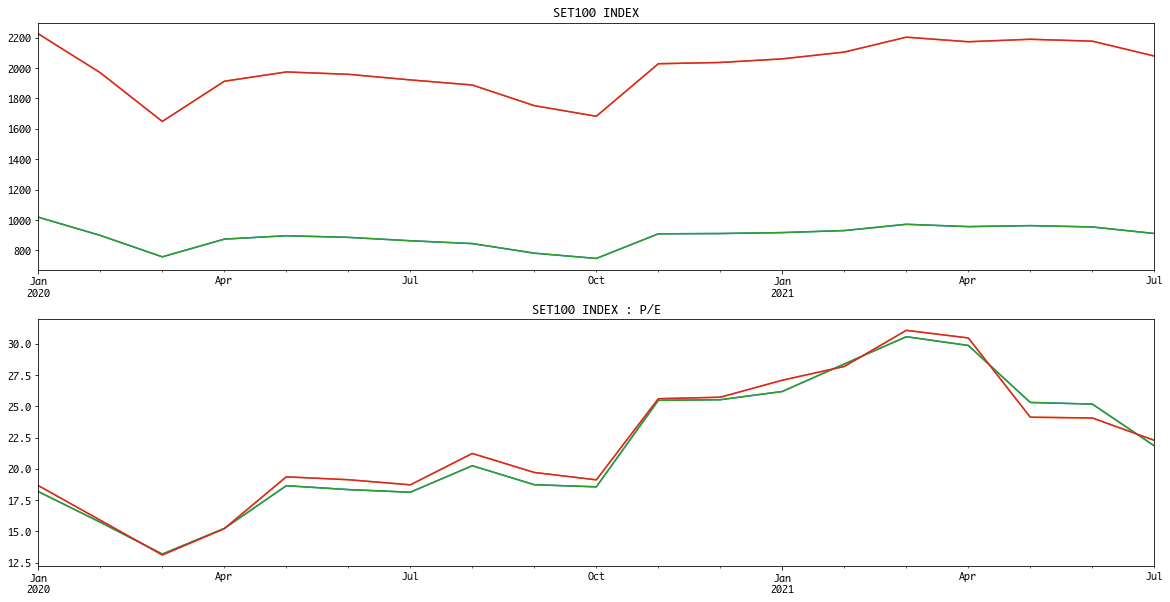

In [40]:
# Create scaled data for stock, and granger

stock_symbol = 'DELTA'
df_stock = get_all_sources_stock_data(stock_symbol)

# -> Granger incorrect way to use this? well it shifted but all other data is null so not good
df_granger_transformed = create_granger_transformed_df(stock_symbol = stock_symbol, granger_period = 10)

df_stock_scaled, stock_scaler = min_max_scaler_transform(df_stock)
df_granger_scaled, granger_scaler = min_max_scaler_transform(df_granger_transformed)


In [41]:
def get_granger_causality_lag(stock_symbol = 'DELTA', granger_period = 10):
    '''
    
    ######## REDO CHECK -> DELETE?
    - Need to change this so taht it only outputs the ones we want from granger causality shifted data, 
    or create new ones with the shifted information
    - Output just the name, index, delay value
    - Can also scope just for the ones that have the things to change by
    - Then ened to change this to datetime in toher one, andthen map it to different datapoints themselves

    
    
    
    Function to take in the stock symbol, analyse the granger causality between the input stock with the rest of the features.
    Then output a dataframe which transformed the data with the delayed lag time.
    
    Granger Causality testing
    - The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another.
    - Granger causality is a statistical concept of causality that is based on prediction. 
    - According to Granger causality, if a signal X1 "Granger-causes" (or "G-causes") a signal X2, then past values of X1 should contain information that helps predict X2 above and beyond the information contained in past values of X2 alone.
    - Based on f test case sum square regression (error)
    - The Sum of Squared regression is the sum of the differences between the predicted value and the mean of the dependent variable.

    p value
    - p value is the statistical significance. 
    - More than 0.05 = there is no significance so no causality from these metrics
    - Therefore, we take p value is less than 0.05

    f test 
    - The F-test is to test whether or not a group of variables has an effect on y, meaning we are to test if these variables are jointly significant.
    - f test to see how significant based on others and square error for each lag time
    - https://tien89.wordpress.com/2010/03/18/testing-multiple-linear-restrictions-the-f-test/
    
    Input:
    - stock_symbol
    - granger_period - For granger causality to calculate
    
    Process:
    - Fetch data related to stock and its curated features
    - Reorder the interested stock_close price information to first column
    - Loop through data to find granger causality for each pair with the first column (with interested data)
    - Identify the most appropriate delay/lag with granger causality testing
    - Apply the lag to the data, and backfill null values

    Output:
    - Dataframe of transformed grangercausality lag
    
    '''
    
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    
    # Get data source for all stocks with its features
    df_data = get_all_sources_stock_data(stock_symbol)

    # Pop the stock name that we want out of the dataframe
    first_column = df_data.pop(stock_symbol + '_CLOSE')

    # Insert the pop data back to the first column
    df_data.insert(0, stock_symbol + '_CLOSE', first_column)
    
    # Create temp dataframe to hold the granger data
    df_granger = pd.DataFrame()
    df_granger_transformed = df_data.copy()
#     df_granger_transformed.index = pd.to_datetime(df_granger_transformed.index)
    
    lag_data = []

    # Loop through each data column and then evaluate the granger causality between each pair with first column of interested stock
    for idx, col in tqdm(enumerate(df_data.columns)):

        # Skip the data of the first column which is our interested stock
        if idx == 0:
            continue

        # Calculate the granger causality of each pair with the first column
        df_granger_raw = grangercausalitytests(pd.concat([df_data.iloc[:,0],df_data.iloc[:,idx]],axis=1), granger_period, verbose=False)
        
        # Create temporary dataframe for holding the granger results
        df_granger_results = pd.DataFrame()
        
        # Loop in the granger results data in order to sort and find the most appropriate lag period
        for num, item in df_granger_raw.items():
            
            # Extract the data and transpose it 
            df_ftest = pd.DataFrame(item[0]['ssr_ftest']).transpose()
            
            # Returned results (Fvalue, pValue, df_denom, df_num) for each of the results
            df_granger_results = pd.concat([df_granger_results, df_ftest],axis=0)
        
        # Rename the column data for ease of access
        df_granger_results.columns = ['Fvalue','pvalue','df_denom','df_num']

        # Sort by the pvalue less than 0.05 for significance, and choose the highest Fvalue
        lag_array = df_granger_results[df_granger_results['pvalue'] < 0.05].sort_values(by='Fvalue', ascending=False).head(1).df_num.values
        
        # Set initial lag value of grangercausality to 0
        lag_value = 0

        # If the value is not zero, then get the lag. otherwise lag_value is zero
        if len(lag_array) != 0:
            lag_value = lag_array[0]
        
        print(lag_value, col)
        lag_data.append((lag_value, col))
    
    # Rename thee dataframe for appropriate column naming
    lag_data = pd.DataFrame(lag_data).rename(columns={0 : 'lag_value', 1 : 'col'})
    
    # Filter out the ones with lag data more than 1
    lag_data = lag_data[lag_data['lag_value'] > 1].sort_values(by='lag_value', ascending=False)

    # Filter out only the columns which have granger causality affect
    df_granger_transformed = df_granger_transformed[lag_data['col']]
    
    return df_granger_transformed, lag_data

  0%|          | 0/9 [00:00<?, ?it/s]

DELTA : is part of SET stock
Returning sector industry info of :  DELTA
Keyword list for Google trend:  ['DELTA', 'เทคโนโลยี', 'ชิ้นส่วนอิเล็กทรอนิกส์', 'หุ้น delta', 'delta airlines']
File already exist....reading from csv


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exec(code_obj, self.user_global_ns, self.user_ns)


0it [00:00, ?it/s]

0 TEAM_OPEN
0 TEAM_HIGH
0 TEAM_LOW
0 TEAM_CLOSE
0 TEAM_VOLUME
0 TEAM_ema10
0 TEAM_ema30
0 TEAM_ema50
0 TEAM_ma10
0 TEAM_ma30
0 TEAM_ma50
0 TEAM_ma100
0 TEAM_rsi2
0 TEAM_rsi6
25.0 TEAM_rsi14
0 TEAM_rsi30
17.0 KCE_OPEN
19.0 KCE_HIGH
0 KCE_LOW
24.0 KCE_CLOSE
17.0 KCE_VOLUME
23.0 KCE_ema10
0 KCE_ema30
0 KCE_ema50
0 KCE_ma10
3.0 KCE_ma30
1.0 KCE_ma50
1.0 KCE_ma100
0 KCE_rsi2
0 KCE_rsi6
0 KCE_rsi14
0 KCE_rsi30
0 HANA_OPEN
0 HANA_HIGH
0 HANA_LOW
0 HANA_CLOSE
17.0 HANA_VOLUME
0 HANA_ema10
0 HANA_ema30
0 HANA_ema50
0 HANA_ma10
0 HANA_ma30
2.0 HANA_ma50
1.0 HANA_ma100
0 HANA_rsi2
0 HANA_rsi6
0 HANA_rsi14
0 HANA_rsi30
9.0 SMT_OPEN
24.0 SMT_HIGH
0 SMT_LOW
0 SMT_CLOSE
5.0 SMT_VOLUME
3.0 SMT_ema10
3.0 SMT_ema30
3.0 SMT_ema50
3.0 SMT_ma10
3.0 SMT_ma30
3.0 SMT_ma50
1.0 SMT_ma100
0 SMT_rsi2
0 SMT_rsi6
0 SMT_rsi14
0 SMT_rsi30
0 METCO_OPEN
0 METCO_HIGH
0 METCO_LOW
0 METCO_CLOSE
0 METCO_VOLUME
0 METCO_ema10
0 METCO_ema30
0 METCO_ema50
3.0 METCO_ma10
0 METCO_ma30
28.0 METCO_ma50
0 METCO_ma100
0 METCO_rsi2


,DELTA_VOLUME,METCO_ma50,SVI_LOW,DELTA_ma100,TEAM_rsi14,SVI_ma10,KCE_CLOSE,SMT_HIGH,DELTA_ema50,KCE_ema10,...,SMT_ema50,DELTA_ma10,SMT_ema10,KCE_ma30,SMT_ema30,SMT_ma10,DELTA_HIGH,NEX_ma100,HANA_ma50,SVI_OPEN
2020-01-01,1077800.0,164.72,3.52,47.49,37.589564,3.468,23.200001,1.20,51.750000,23.200001,...,1.180000,51.75,1.180000,21.176667,1.180000,1.127,53.75,2.888975,34.100,3.60
2020-01-02,1077800.0,164.72,3.52,47.49,37.589564,3.468,23.200001,1.20,51.750000,23.200001,...,1.180000,51.75,1.180000,21.176667,1.180000,1.127,53.75,2.888975,34.100,3.60
2020-01-03,964700.0,164.72,3.48,47.49,37.589564,3.468,22.400000,1.21,51.740196,23.054546,...,1.180392,51.75,1.181818,21.176667,1.180645,1.127,53.00,2.888975,34.100,3.54
2020-01-05,964700.0,164.72,3.48,47.49,37.589564,3.468,22.400000,1.21,51.740196,23.054546,...,1.180392,51.75,1.181818,21.176667,1.180645,1.127,53.00,2.888975,34.100,3.54
2020-01-06,633700.0,164.72,3.42,47.49,37.589564,3.468,21.500000,1.19,51.681757,22.771901,...,1.178024,51.75,1.170578,21.176667,1.176733,1.127,51.25,2.888975,34.100,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,816900.0,240.10,4.84,497.36,73.853674,4.818,80.250000,6.30,555.545347,81.504183,...,6.366601,560.20,6.296200,79.725000,6.447426,6.265,576.00,6.817500,73.075,4.84
2021-08-28,816900.0,240.10,4.84,497.36,73.853674,4.818,80.250000,6.30,555.545347,81.504183,...,6.366601,560.20,6.296200,79.725000,6.447426,6.265,576.00,6.817500,73.075,4.84
2021-08-29,816900.0,240.10,4.84,497.36,73.853674,4.818,80.250000,6.30,555.545347,81.504183,...,6.366601,560.20,6.296200,79.725000,6.447426,6.265,576.00,6.817500,73.075,4.84
2021-08-30,816900.0,240.42,4.82,497.36,61.462354,4.824,78.250000,6.35,555.545347,80.912513,...,6.360068,560.20,6.278709,79.850000,6.431463,6.265,576.00,6.858500,73.215,4.86


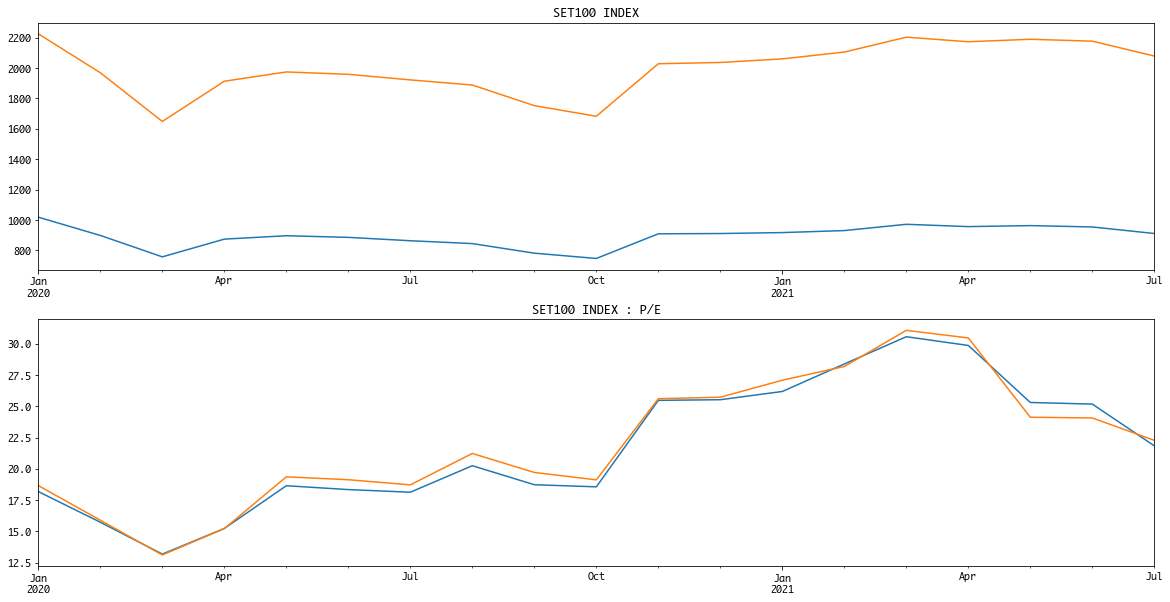

In [42]:
df2_granger, lag_data = get_granger_causality_lag('DELTA', 30)
df2_granger

In [43]:
##### done for the train_test and train_pred case with 200 train data, and test set based on its lag_value

# Create group by data for the values to iterate
lag_data_col = lag_data.groupby('lag_value').col.apply(list).reset_index().sort_values(by='lag_value',ascending=False)

train_test_list_array = []
train_pred_list_array = []
col_accum = []

df_data = df_stock.copy()
df_data.index = pd.to_datetime(df_data.index)

df_stock_data = df_stock['DELTA_CLOSE']

for idx, data in lag_data_col.iterrows():
    df2_granger[data['col']]
    
    for col in data['col']:
        col_accum.append(col)
    
    lag_value = int(data['lag_value'])
    
    df_train = df2_granger[col_accum][-(200 + 50):-50]
    df_test = df2_granger[col_accum][-50:]
    
    df_stock_data_train = df_stock_data[-(200 + 50):-50]
    df_stock_data_test = df_stock_data[-50:]
    
    train_test_list_array.append([lag_value, df_train, df_test, df_stock_data_train, df_stock_data_test])
    

    
    shifted_data = df_data[col_accum].shift(periods=lag_value,freq='D')
    shifted_data_y = df_data['DELTA_CLOSE'].shift(periods=lag_value,freq='D')

    # this is for varying the data
    df_train_pred = shifted_data[col_accum][-(200 + lag_value):-lag_value]
    df_test_pred = shifted_data[col_accum][-lag_value:]
                
#     df_stock_data_train_pred = df_stock_data[-(200 + lag_value):-lag_value]
#     df_stock_data_test_pred = df_stock_data[-lag_value:]
    
    df_stock_data_train_pred = shifted_data_y[-(200 + lag_value):-lag_value]
    df_stock_data_test_pred = shifted_data_y[-lag_value:]
        
    train_pred_list_array.append([lag_value, df_train_pred, df_test_pred, df_stock_data_train_pred, df_stock_data_test_pred])
    
    
    
    ###### TOCHECK -> train_pred[x][1] and train_pred[x][3] -> date does not match , and 2 and 4 does nto match
    
#     train_test_list_array
#     print(lag_value, data['col'])
#     print(col_accum)
#     print(df2_granger[col_accum])

In [44]:
df_data['DELTA_CLOSE']

2020-01-01     51.75
2020-01-02     51.75
2020-01-03     51.50
2020-01-05     51.50
2020-01-06     50.25
               ...  
2021-08-27    566.00
2021-08-28    566.00
2021-08-29    566.00
2021-08-30    566.00
2021-08-31    566.00
Name: DELTA_CLOSE, Length: 527, dtype: float64

In [45]:
train_test_list_array[15][2]

,DELTA_VOLUME,METCO_ma50,SVI_LOW,DELTA_ma100,TEAM_rsi14,SVI_ma10,KCE_CLOSE,SMT_HIGH,DELTA_ema50,KCE_ema10,...,KCE_VOLUME,HANA_VOLUME,NER_top3_SET100_corr,DELTA_OPEN,DELTA_LOW,DELTA_ma30,industry_gg_interest,DELTA_ema10,SMT_OPEN,DELTA_ma50
2021-07-13,691200.0,252.10,4.74,442.32,65.956019,4.796,74.75,7.10,519.438911,73.961621,...,21939300.0,17136400.0,7.65,600.0,582.0,562.266667,39.0,572.828456,7.00,513.70
2021-07-14,912100.0,251.02,4.78,443.34,73.291640,4.794,74.50,7.50,521.578562,74.059508,...,10162200.0,16342800.0,7.90,586.0,572.0,562.933333,39.0,573.041464,6.90,517.58
2021-07-15,10153300.0,250.02,4.84,445.26,68.029561,4.792,74.50,7.45,526.693128,74.139598,...,9728600.0,10069500.0,7.75,582.0,574.0,566.533333,39.0,587.397561,7.45,522.88
2021-07-16,1886200.0,249.18,4.82,446.68,68.436308,4.794,75.00,7.00,529.018888,74.296034,...,8048500.0,13203600.0,8.25,632.0,578.0,567.800000,39.0,587.143459,6.95,526.98
2021-07-17,1886200.0,249.18,4.82,446.68,68.436308,4.794,75.00,7.00,529.018888,74.296034,...,8048500.0,13203600.0,8.25,632.0,578.0,567.800000,39.0,587.143459,6.95,526.98
2021-07-18,1886200.0,249.18,4.82,446.68,68.436308,4.794,75.00,7.00,529.018888,74.296034,...,8048500.0,13203600.0,8.25,632.0,578.0,567.800000,40.0,587.143459,6.95,526.98
2021-07-19,694200.0,248.14,4.80,448.22,70.459984,4.798,76.00,6.90,530.469128,74.605846,...,15644600.0,10058100.0,8.25,572.0,554.0,567.333333,40.0,583.299194,6.70,530.74
2021-07-20,727900.0,246.96,4.84,449.62,70.862351,4.802,74.50,6.85,531.784064,74.586602,...,10864500.0,5494700.0,8.00,560.0,548.0,566.533333,40.0,579.790250,6.85,534.44
2021-07-21,435700.0,245.66,4.90,451.24,67.875387,4.830,76.00,6.85,533.282728,74.843583,...,14158100.0,5857900.0,7.95,562.0,562.0,566.400000,40.0,578.010204,6.75,538.76
2021-07-22,790900.0,244.48,4.96,452.24,77.193082,4.858,81.50,7.00,535.193209,76.053841,...,48810400.0,26850200.0,8.05,580.0,568.0,566.933333,40.0,578.735622,6.80,544.10


In [46]:
train_pred_list_array[2][3]

2021-01-30    486.0
2021-01-31    528.0
2021-02-01    656.0
2021-02-02    568.0
2021-02-03    564.0
              ...  
2021-08-27    584.0
2021-08-28    584.0
2021-08-29    592.0
2021-08-30    600.0
2021-08-31    602.0
Name: DELTA_CLOSE, Length: 200, dtype: float64

In [47]:
train_test_list_array[2][3]

2020-12-02    232.0
2020-12-03    247.0
2020-12-04    257.0
2020-12-06    257.0
2020-12-08    327.0
              ...  
2021-07-08    560.0
2021-07-09    588.0
2021-07-10    588.0
2021-07-11    588.0
2021-07-12    598.0
Name: DELTA_CLOSE, Length: 200, dtype: float64

In [48]:
def create_train_predict_with_granger_causality(df_stock, lag_data, train_size=200):
    '''
    
    train test data creation
    train predict data creation
    
    note, another function already analyse the prediction adn accuracy with testing for the number of error cases
    with optimal at 200 data to train
    
    here, to create train-test, adn train-predict with granger causality applied
    
    input
    df_stock = stock data
    lag_data = data from other fucntion to show stock and its lag valuee, and the col that lagged
    train_size = number of samples for training
    
    '''
    
    ############ -> test adding concat with previous data
    # Create train test input (stock_data, lag_data)
    #  need two set. one for real time and one for performance teesting only
    #### Test creating the test dataframe set


    
    
    
    
    
    

    
    
    
    
    
    

# TODO
1. granger dataframe to change -> it should include nan and also shift data down




In [49]:
# TODO
# 0. Move DELTA_close to first column data -> done
# 1. Create loop...to loop DELTA_CLOSE with other columns
# 2. Find granger between them -> Process done
# 3. Get the value for shift delay -> done
# 4. Shift delay of data -> done
# 5. backfill data -> done
# 6. concat create new granger dataframe -> done
### 7. scale the results to prepare for modelling

### Create train and test dataset
Create train adn test dataset to separate for usage

Note, need to ensure that this gets updated in rolling as well.
otherwise we are going to just use old data to predict new things


Complication issue as it is time series prediction

1. Train test with the period of 450 items, then 400 items, and 350, 300, 250, 200, 150, 100, 50 items - (10, 30, 50)
1. Train test with different period that we take for rolling (ie take 202001-202003 202005-202010) -> Optional -> otherwise always test rolling with latest data backdate
2. Compare their performance for each part
3. Test data with latest 50 items (rolling)
4. Review the different models and then usage for performance comparison
5. Prep data for prediction -> step for prediction later


TODO
- Train-test data with up to current date data and prediction
- Performance comparison
- Predict dataset by data itself only
- Predict dataset by other features -> the data with forward shift from granger causality ebcasue predict future


To Have
1. train_test breakdown function -> so can use in models for train and test easily + can use to predict data with iteself from train, but different period -> set period
2. predict_test function -> predict for adding features


Have a way top do it now
- Shift the data, then scope it
- Then clean to add to each future dataframe row for prediction

Now***********
1. Clean up for the prophet usage -> use raw data without granger cleanup
2. Create train test with different train/test pair set
3. Test performance of prophet output, 
4. compare different train test periods
5. compare different algorithms
6. prepare prediction train/predict dataset
7. predict future case

In [50]:
# df_train = df_prophet_delta2.iloc[-455:-90,:]
# df_test = df_prophet_delta2.iloc[-90:,:]

# m = Prophet()
# # for col in df_train.columns:
# #     if col not in ('y','ds'):
# #         m.add_regressor(col)
# #         future[col] = df_test[col]
# m.add_regressor('NEX_OPEN')
# m.fit(df_train)
# # Make future dataframe (currently set to 0 for prediction)
# future = m.make_future_dataframe(periods=120)
# # future['NEX_OPEN'] = df_prophet_delta2['NEX_OPEN'] # -> shoudl not use
# future['NEX_OPEN'] = df_train['NEX_OPEN']
# # for col in df_train.columns:
# #     if col not in ('y','ds'):
# # #         m.add_regressor(col)
# #         future[col] = df_train[col]

# forecast = m.predict(future)
# fig1 = m.plot(forecast)

# # mean_squared_error(df_test['y'], forecast['yhat'][:len(df_test['y'])], squared=False)

In [51]:
def create_train_test_dataset_stock(df):
    '''
    Separate the data for train and test dataset.
    Input dataframe and then scope their output for different train/test pairing.
    This data is based on the latest data input and will get based on index.
    
    Cases
    - train x test row data
    - (400, 350, 300, 250, 200, 150, 100, 50) x (100, 50, 30, 10, 7, 5, 2)
    
    Data here is based on latest date and then breakdown the number of rows to create the train/test dataset.
    For example, 400/50 train/test data = 450 rows backdate train, 50 rows backdate test
    
    Here, for the different test set, we have different scope so that we are able to see how accurate we can predict
    for longer period vs shorter periods and their performance comparison.
    
    Note, for actual prediction of real-time data, we will need to work with granger causality to see which ones have 
    a relationship with our data and the only use those to predict since we are unable to predict with all the data.
    
    Input:
    - Dataframe stock data (use grangercausality transformed stock data)
    
    Output:
    - Train/Test dataset pairings as tuple for different cases
    
    '''
    
    array_df_train_test = []
    
    pair_value = [(400,50)
                , (350,50)
                , (300,50)
                , (250,50)
                , (200,50)
                , (150,50)
                , (100,50)
                , (50,50)
                , (30,50)
                , (400,30)
                , (350,30)                  
                , (300,30)
                , (250,30)
                , (200,30)
                , (150,30)
                , (100,30)                  
                , (50,30)
                , (30,30)
                , (400,10)
                , (350,10)                  
                , (300,10)
                , (250,10)
                , (200,10)
                , (150,10)
                , (100,10)                  
                , (50,10)
                , (30,10)
                , (400,7)
                , (350,7)                  
                , (300,7)
                , (250,7)
                , (200,7)
                , (150,7)
                , (100,7)                  
                , (50,7)
                , (30,7)
                , (400,5)
                , (350,5)                  
                , (300,5)
                , (250,5)
                , (200,5)
                , (150,5)
                , (100,5)                  
                , (50,5)
                , (30,5)
                , (400,2)
                , (350,2)                  
                , (300,2)
                , (250,2)
                , (200,2)
                , (150,2)
                , (100,2)                  
                , (50,2)
                , (30,2)
    ]
    
    for train_rows, test_rows in tqdm(pair_value):
        train_data = df.iloc[-(train_rows + test_rows):-test_rows,:]
        test_data = df.iloc[-test_rows:,:]
        array_df_train_test.append([(train_rows,test_rows),train_data,test_data])
    
    return array_df_train_test

In [52]:
def create_train_test_dataset_stock_specific(df, train_size = 200, test_size = 30):
    '''
    
    train test based on the number input
    
    '''
    
    train_data = df.iloc[-(train_size + test_size):-test_size,:]
    test_data = df.iloc[-test_size:,:]
    
    return train_data, test_data

In [53]:
####### TEST TODO
# - Test with using all data
# - Test with only data from granger causality and see hwo accurate it is
# - For real-time prediction, need to test with multiple features, and then see how accurate it is compared too
# ---- since it would be unwise to infser the same performance if we use all features, or only limited few

In [54]:
def train_test_stock_prediction_prophet(df, stock_symbol = 'DELTA', showPlot=False):
    '''
    test prophet model
    output the test results of different train dataset sizing to see which is most optimal
    
    purpose is to identify the best range of data to check for the stock for testing
    
    
    note, this is only using the data from the stock itself and not any other features for prediction
    
    Based on this, we can see which paring and how much data we should use
    
    
    Input:
    - stock_symbol that is looking to test
    - Dataframe of stock data list
    - showPlot show visualisation or not for each test
    
    Output:
    - The prediction results for differen training size dat
    - Output the list of results with combination data
    - Output highest paring data
    
    '''
    df_train_test_array = create_train_test_dataset_stock(df)
    df_results = []
    
    for (train_value,test_value), df_train, df_test in tqdm(df_train_test_array):
        
        # Rename columns appropriately for prophet requirement
        df_train = df_train.reset_index().rename(columns={stock_symbol + '_CLOSE': 'y','index' : 'ds'})
        df_test = df_test.reset_index().rename(columns={stock_symbol + '_CLOSE': 'y','index' : 'ds'})
        
        m = Prophet()
        m.fit(df_train)
        future = m.make_future_dataframe(periods=len(df_test))
        forecast = m.predict(future)
        
        if showPlot:
            fig1 = m.plot(forecast)
        
        # performance root mean_squared_error jsut for the predicted part
        rmse = mean_squared_error(df_test['y'], forecast['yhat'][:len(df_test['y'])], squared=False)

        df_results.append([(train_value,test_value), rmse])
        
    df_results = pd.DataFrame(df_results).rename(columns={0 : 'train_test_pair', 1 : 'rmse'})
    return df_results
    

In [55]:
##### Run in actual code for testing and showing results
######## Data output just to justify how we can still accept the data for 5 days ahead informaiton prediction
#### note but this case is using all features, we need ot test again for when doing granger

# df_res1 = train_test_stock_prediction_prophet(get_all_sources_stock_data('DELTA'), stock_symbol = 'DELTA').add_prefix('DELTA_')
# df_res2 = train_test_stock_prediction_prophet(get_all_sources_stock_data('KCE'),stock_symbol='KCE').add_prefix('KCE_')
# df_res6 = train_test_stock_prediction_prophet(get_all_sources_stock_data('KBANK'),stock_symbol='KBANK').add_prefix('KBANK_')
# df_res7 = train_test_stock_prediction_prophet(get_all_sources_stock_data('SCB'),stock_symbol='SCB').add_prefix('SCB_')
# # df_res8 = train_test_stock_prediction_prophet(get_all_sources_stock_data('SCC'),stock_symbol='SCC').add_prefix('SCC_')
# df_res9 = train_test_stock_prediction_prophet(get_all_sources_stock_data('CPALL'),stock_symbol='CPALL').add_prefix('CPALL_')

# # # Then shows that we select optimal one etc
# pd.concat([df_res1
#            ,df_res2
# #            ,df_res3
# #            ,df_res4
# #            ,df_res5
#            ,df_res6
#            ,df_res7
# #            ,df_res8
#            ,df_res9
#           ],axis=1).to_csv('20210828_test_prophet_rmse_pair_data.csv')



In [56]:
# mse_data = pd.concat([df_res1
#            ,df_res2
#            ,df_res6
#            ,df_res7
#            ,df_res9
#           ],axis=1)
# mse_data

In [57]:
# plt.figure(figsize=(15,6))
# # sns.lineplot(data=mse_data, x = mse_data.index,y = 'DELTA_mse')
# # sns.lineplot(data=mse_data, x = pair_value_str,y = 'DELTA_mse')
# sns.lineplot(data=mse_data, x = pair_value_str,y = 'KCE_rmse')
# sns.lineplot(data=mse_data, x = pair_value_str,y = 'KBANK_rmse')
# sns.lineplot(data=mse_data, x = pair_value_str,y = 'SCB_rmse')
# sns.lineplot(data=mse_data, x = pair_value_str,y = 'CPALL_rmse')
# plt.grid()
# plt.xticks(rotation=90);
# # plt.xticks(np.arange(0, 140, step=10),rotation=90)


In [58]:
def plot_rmse_compare_facebook_prophet_train_test_results(safe_file=False, show_all = False):
    '''
    Plot out the train/test pairing for facebook prophet
    
    x-axis = (train_row, test_row)
    y-axis = RMSE of the stock close price prediction
    
    Shows the plot fo the distribution of the trained data and the predicted results
    
    From this, we are going to deduce that it is best to use the data set at 200 backward samples for our model.
    By doing this, we can be sure to only include the data range that has an impact of the upcoming predicted price.
    
    Input:
    - save_file flag to note whether we want to save the data to a separate csv file or not
    - show_all flag to show all data or only the relevant ones. Here we exclude DELTA as high RMSE but may include
    
    Output:
    - Visualised plots for the data to show
    - rmse_data (root mean square error)
    
    '''
    
    if show_all:
        df_res1 = train_test_stock_prediction_prophet(get_all_sources_stock_data('DELTA'), stock_symbol = 'DELTA').add_prefix('DELTA_')
    df_res2 = train_test_stock_prediction_prophet(get_all_sources_stock_data('KCE'),stock_symbol='KCE').add_prefix('KCE_')
    df_res6 = train_test_stock_prediction_prophet(get_all_sources_stock_data('KBANK'),stock_symbol='KBANK').add_prefix('KBANK_')
    df_res7 = train_test_stock_prediction_prophet(get_all_sources_stock_data('SCB'),stock_symbol='SCB').add_prefix('SCB_')
    df_res9 = train_test_stock_prediction_prophet(get_all_sources_stock_data('CPALL'),stock_symbol='CPALL').add_prefix('CPALL_')

    if show_all:
        rmse_data = pd.concat([df_res1
               ,df_res2
               ,df_res6
               ,df_res7
               ,df_res9
              ],axis=1)
    else:
        rmse_data = pd.concat([df_res2
               ,df_res6
               ,df_res7
               ,df_res9
              ],axis=1)
    
    pair_value_str = ['(400,50)'
                , '(350,50)'
                , '(300,50)'
                , '(250,50)'
                , '(200,50)'
                , '(150,50)'
                , '(100,50)'
                , '(50,50)'
                , '(30,50)'
                , '(400,30)'
                , '(350,30)'                  
                , '(300,30)'
                , '(250,30)'
                , '(200,30)'
                , '(150,30)'
                , '(100,30)'                 
                , '(50,30)'
                , '(30,30)'
                , '(400,10)'
                , '(350,10)'               
                , '(300,10)'
                , '(250,10)'
                , '(200,10)'
                , '(150,10)'
                , '(100,10)'                  
                , '(50,10)'
                , '(30,10)'
                , '(400,7)'
                , '(350,7)'                  
                , '(300,7)'
                , '(250,7)'
                , '(200,7)'
                , '(150,7)'
                , '(100,7)'                  
                , '(50,7)'
                , '(30,7)'
                , '(400,5)'
                , '(350,5)'                 
                , '(300,5)'
                , '(250,5)'
                , '(200,5)'
                , '(150,5)'
                , '(100,5)'                  
                , '(50,5)'
                , '(30,5)'
                , '(400,2)'
                , '(350,2)'                  
                , '(300,2)'
                , '(250,2)'
                , '(200,2)'
                , '(150,2)'
                , '(100,2)'                  
                , '(50,2)'
                , '(30,2)'
    ]
    
    plt.figure(figsize=(15,6))
    
    if show_all:
        sns.lineplot(data=rmse_data, x = pair_value_str,y = 'DELTA_rmse')
    
    sns.lineplot(data=rmse_data, x = pair_value_str,y = 'KCE_rmse')
    sns.lineplot(data=rmse_data, x = pair_value_str,y = 'KBANK_rmse')
    sns.lineplot(data=rmse_data, x = pair_value_str,y = 'SCB_rmse')
    sns.lineplot(data=rmse_data, x = pair_value_str,y = 'CPALL_rmse')
    plt.grid()
    plt.xticks(rotation=90);
    
    # Save file to CSV for later reference
    if safe_file:
        rmse_data.to_csv('20210828_test_prophet_rmse_pair_data.csv')
        
    return rmse_data

In [59]:
# rmse_data2 = plot_rmse_compare_facebook_prophet_train_test_results()
# rmse_data2

In [60]:
# df_train

In [61]:
# df_stock
# # NOTE -> To use this, add in the granger_causality transformed dataframe instead, or test both
# df_train1, df_test1 = create_train_test_dataset_stock_specific(df_stock, 200,30)

In [62]:
# df_train1

In [63]:
# # SVR regression

# from sklearn import svm

# #Create a svm Classifier
# # clf = svm.SVC(kernel='linear') # Linear Kernel

# # regression
# clf = svm.SVR(kernel = 'poly') 
# # clf = svm.SVR(kernel = 'linear') 

# #Train the model using the training sets
# # clf.fit(x_train, y_train)
# clf.fit(df_train1[['NEX_CLOSE','SVI_CLOSE']], df_train1[['DELTA_CLOSE']])

# #Predict the response for test dataset
# y_pred = clf.predict(df_test1[['NEX_CLOSE','SVI_CLOSE']])

In [64]:
train_test_list_array[2][2]

,DELTA_VOLUME,METCO_ma50,SVI_LOW
2021-07-13,691200.0,252.10,4.74
2021-07-14,912100.0,251.02,4.78
2021-07-15,10153300.0,250.02,4.84
2021-07-16,1886200.0,249.18,4.82
2021-07-17,1886200.0,249.18,4.82
2021-07-18,1886200.0,249.18,4.82
2021-07-19,694200.0,248.14,4.80
2021-07-20,727900.0,246.96,4.84
2021-07-21,435700.0,245.66,4.90
2021-07-22,790900.0,244.48,4.96


In [208]:
data_point = 10


# # prep data
train_x = train_test_list_array[data_point][1]
test_x = train_test_list_array[data_point][2]
train_y = train_test_list_array[data_point][3]
test_y = train_test_list_array[data_point][4]

### prep data -> not work for pred yet
# train_x = train_pred_list_array[data_point][1]
# test_x = train_pred_list_array[data_point][2]
# train_y = train_pred_list_array[data_point][3]
### test_y = train_pred_list_array[data_point][4] -> Does not exist -> calculate wrong

### df_transformed, scaler = min_max_scaler_transform
df_transformed, scaler = min_max_scaler_transform(pd.concat([train_x,train_y],axis=1))



train_x = df_transformed.drop('DELTA_CLOSE',axis=1)
train_y = df_transformed['DELTA_CLOSE']
temp_scale_test = pd.DataFrame(scaler.transform(pd.concat([test_x,test_y], axis=1)))

temp_scale_test.columns = np.concatenate((test_x.columns, ['DELTA_CLOSE']))
temp_scale_test

test_x = temp_scale_test.drop('DELTA_CLOSE',axis=1)
test_y = temp_scale_test['DELTA_CLOSE']

print('lag_value:', train_test_list_array[data_point][0])
print('train size:', train_x.shape[0])
print('test size:', test_x.shape[0])
print('features used:', train_x.shape[1])
print('feature columns:', train_x.columns.values)

lag_value: 16
train size: 200
test size: 50
features used: 20
feature columns: ['DELTA_VOLUME' 'METCO_ma50' 'SVI_LOW' 'DELTA_ma100' 'TEAM_rsi14'
 'SVI_ma10' 'KCE_CLOSE' 'SMT_HIGH' 'DELTA_ema50' 'KCE_ema10' 'DELTA_ema30'
 'SVI_ema10' 'SVI_CLOSE' 'BOL_top3_SET100_corr' 'SVI_HIGH' 'KCE_HIGH'
 'KCE_OPEN' 'KCE_VOLUME' 'HANA_VOLUME' 'NER_top3_SET100_corr']


In [209]:
train_y

2020-12-02    0.000000
2020-12-03    0.029070
2020-12-04    0.048450
2020-12-06    0.048450
2020-12-08    0.184109
                ...   
2021-07-08    0.635659
2021-07-09    0.689922
2021-07-10    0.689922
2021-07-11    0.689922
2021-07-12    0.709302
Name: DELTA_CLOSE, Length: 200, dtype: float64

In [210]:
train_y

2020-12-02    0.000000
2020-12-03    0.029070
2020-12-04    0.048450
2020-12-06    0.048450
2020-12-08    0.184109
                ...   
2021-07-08    0.635659
2021-07-09    0.689922
2021-07-10    0.689922
2021-07-11    0.689922
2021-07-12    0.709302
Name: DELTA_CLOSE, Length: 200, dtype: float64

In [211]:
# LINEAR regression

reg = LinearRegression().fit(train_x,train_y)
pred_reg = reg.predict(test_x)
pred_reg
# Then use result compare to test_y

array([0.63677972, 0.57710735, 0.66450779, 0.60550105, 0.60550105,
       0.60550105, 0.57409614, 0.59559309, 0.58223183, 0.65199293,
       0.64693032, 0.64693032, 0.64693032, 0.64693032, 0.60556129,
       0.60556129, 0.59891726, 0.64067691, 0.64067691, 0.64067691,
       0.63625934, 0.61750045, 0.63035468, 0.60113542, 0.65518128,
       0.65518128, 0.65518128, 0.67388544, 0.6603939 , 0.68424941,
       0.68424941, 0.66692304, 0.66692304, 0.66692304, 0.69219605,
       0.74680212, 0.74307584, 0.78152358, 0.78405511, 0.78405511,
       0.78405511, 0.71758173, 0.70222591, 0.70774282, 0.66178819,
       0.67264931, 0.67264931, 0.67264931, 0.66745877, 0.65767209])

0.07319793658855733

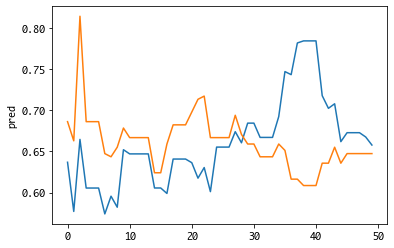

In [212]:

# sns.lineplot(pd.DataFrame(pred_reg), x = np.range(1,))
# sns.lineplot(y = list(test_y))
# list(test_y)
df_pred_xx = pd.DataFrame(pred_reg).rename(columns={0:'pred'})
df_pred_xx['pred']

df_test_xx = test_y.reset_index().drop('index',axis=1)

sns.lineplot(data=df_pred_xx, x = df_pred_xx.index, y='pred')
sns.lineplot(data=df_test_xx, x = df_test_xx.index, y='DELTA_CLOSE')

mean_squared_error(df_pred_xx['pred'],df_test_xx['DELTA_CLOSE'], squared=False)

In [214]:
from sklearn.ensemble import RandomForestRegressor
# >>> from sklearn.datasets import make_regression
# >>> X, y = make_regression(n_features=4, n_informative=2,
# ...                        random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(train_x,train_y)
pred_regr = regr.predict(test_x)

df_pred_xx2 = pd.DataFrame(pred_regr).rename(columns={0:'pred'})

df_test_xx = test_y.reset_index().drop('index',axis=1)
mean_squared_error(df_pred_xx2['pred'],df_test_xx['DELTA_CLOSE'], squared=False)

0.12742896364853726

In [215]:
# test_x.index = train_test_list_array[2][2].index

In [216]:
# SVR regression
# from sklearn import svm

# regression
# clf_poly = svm.SVR(kernel = 'poly') 
# clf_linear = svm.SVR(kernel = 'linear') 

#Train the model using the training sets
# clf_poly.fit(train_x, train_y)
# clf_linear.fit(train_x, train_y)

#Predict the response for test dataset
# svm_pred_poly = clf_poly.predict(test_x)
# svm_pred_linear = clf_linear.predict(test_x)

# df_pred_xx3 = pd.DataFrame(svm_pred_poly).rename(columns={0:'pred'})
# df_pred_xx4 = pd.DataFrame(svm_pred_linear).rename(columns={0:'pred'})

# print('svm poly: ',mean_squared_error(df_pred_xx3['pred'],df_test_xx['DELTA_CLOSE'], squared=False))
# print('svm linear: ',mean_squared_error(df_pred_xx4['pred'],df_test_xx['DELTA_CLOSE'], squared=False))

In [217]:
from sklearn.svm import LinearSVR
lin_svr_regr = LinearSVR(random_state=0, tol=1e-5)
lin_svr_regr.fit(train_x, train_y)
lin_svr_pred = lin_svr_regr.predict(test_x)

df_pred_xx6 = pd.DataFrame(lin_svr_pred).rename(columns={0:'pred'})
mean_squared_error(df_pred_xx6['pred'],df_test_xx['DELTA_CLOSE'], squared=False)

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.11804950993150158

In [218]:

from sklearn.ensemble import GradientBoostingRegressor

reg2 = GradientBoostingRegressor(random_state=0)
reg2.fit(train_x, train_y)
pred_reg2 = reg2.predict(test_x)

df_pred_xx5 = pd.DataFrame(pred_reg2).rename(columns={0:'pred'})
mean_squared_error(df_pred_xx5['pred'],df_test_xx['DELTA_CLOSE'], squared=False)


# gradient_params = {'learning_rate':[0.05,0.1,0.2],'max_depth':[5,10,15],'n_estimators':[50,100,200],'min_samples_leaf':[1,2,5]}
# reg = RandomizedSearchCV(estimator= GradientBoostingRegressor(random_state=0,criterion='mse'),param_distributions=gradient_params,cv=3)
# reg.fit(train_x,train_y)
# newreg = reg.best_estimator_
# pred = newreg.predict(test_x)

0.03973841106563149

<AxesSubplot:ylabel='pred'>

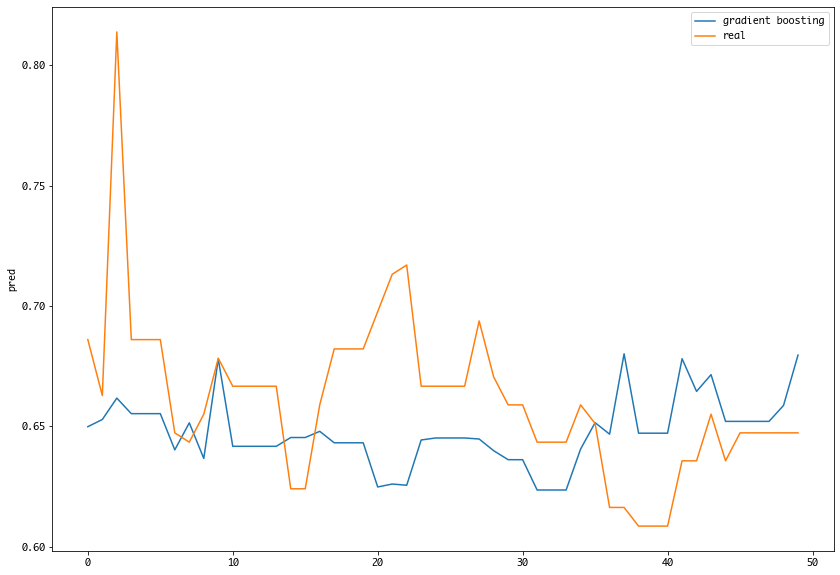

In [219]:

# sns.lineplot(pd.DataFrame(pred_reg), x = np.range(1,))
# sns.lineplot(y = list(test_y))
# list(test_y)
plt.figure(figsize=(14,10))

sns.lineplot(data=df_pred_xx5, x = df_pred_xx5.index, y='pred', label='gradient boosting')
sns.lineplot(data=df_test_xx, x = df_test_xx.index, y='DELTA_CLOSE', label='real')



In [220]:
# SVR regression

from sklearn import svm

#Create a svm Classifier
# clf = svm.SVC(kernel='linear') # Linear Kernel

# regression
clf = svm.SVR(kernel = 'poly') 
# clf = svm.SVR(kernel = 'linear') 

#Train the model using the training sets
# clf.fit(x_train, y_train)
clf.fit(train_x, train_y)

#Predict the response for test dataset
y_pred = clf.predict(test_x)

df_pred_xx8 = pd.DataFrame(y_pred).rename(columns={0:'pred'})

mean_squared_error(df_pred_xx8['pred'],df_test_xx['DELTA_CLOSE'], squared=False)


0.22452612114795534

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.97357
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       227.854    0.00473284         65.24    6.33e-05       0.001       97  LS failed, Hessian reset 
      94       228.326   0.000525717       76.9161   7.307e-06       0.001      203  LS failed, Hessian reset 
      99       228.352   0.000109945       62.2339           1           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       228.366   3.40509e-05        54.825   4.566e-07       0.001      274  LS failed, Hessian reset 
     138       228.367   1.12096e-06       63.1101   1.588e-08       0.001      335  LS failed, Hessian reset 
     161       228.367   3.40556e-07        60.905   5.597e-09       0.001      398  LS failed, Hessian reset 
     169       228.367   2.27292e-09       76.4258     0.05618     0.05618      410   
Optimization terminated normally: 
  Convergen

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


0.13034466464861263

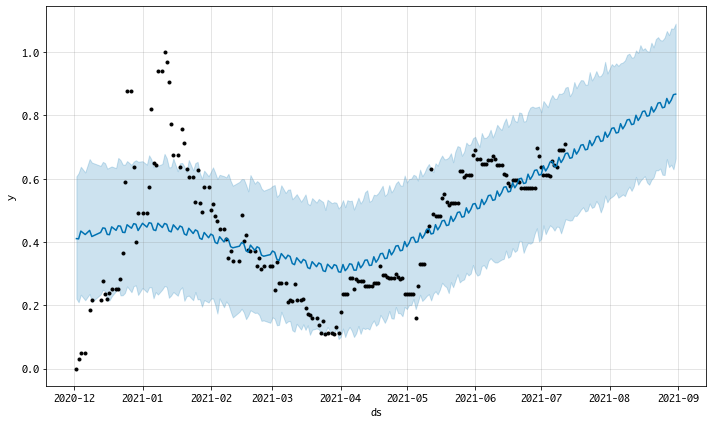

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


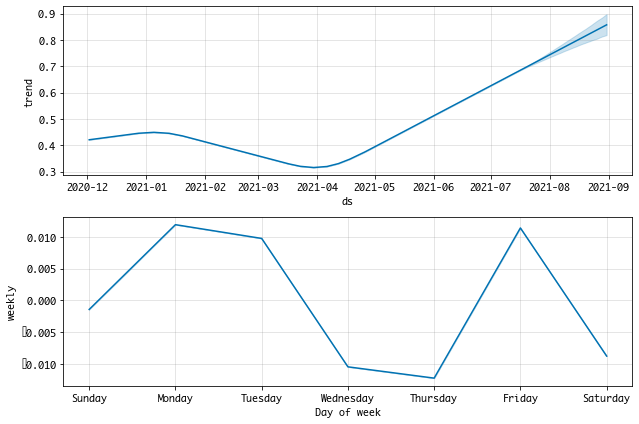

In [221]:
from prophet import Prophet

temp_prophet_df = pd.concat([train_y.rename('y'),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})

m = Prophet()

train_y
m.fit(temp_prophet_df)
future = m.make_future_dataframe(periods=len(test_x))
forecast = m.predict(future)
m.plot(forecast)
m.plot_components(forecast)

df_pred_xx7 = pd.DataFrame(forecast['yhat'][-50:]).rename(columns={0:'pred'})
mean_squared_error(df_pred_xx7['yhat'],df_test_xx['DELTA_CLOSE'], squared=False)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.97357
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        449.25    0.00186051       109.226       0.759       0.759      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       455.069     0.0133302       170.413      0.5865      0.5865      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        458.62   4.46438e-06       98.9448           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323        458.62   7.96399e-09       98.8996      0.5818      0.5818      370   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


0.07738600199469443

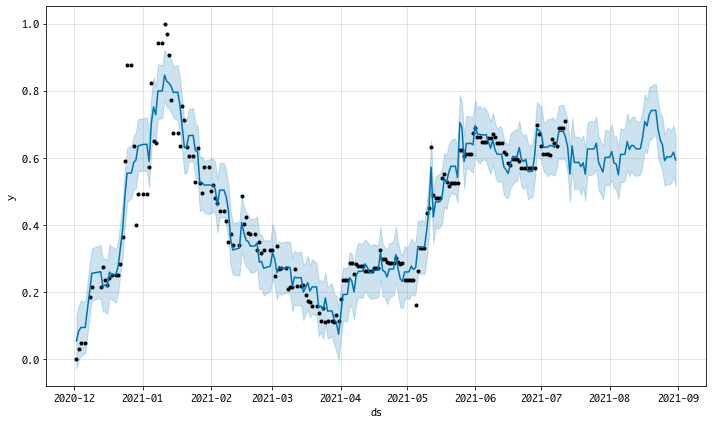

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


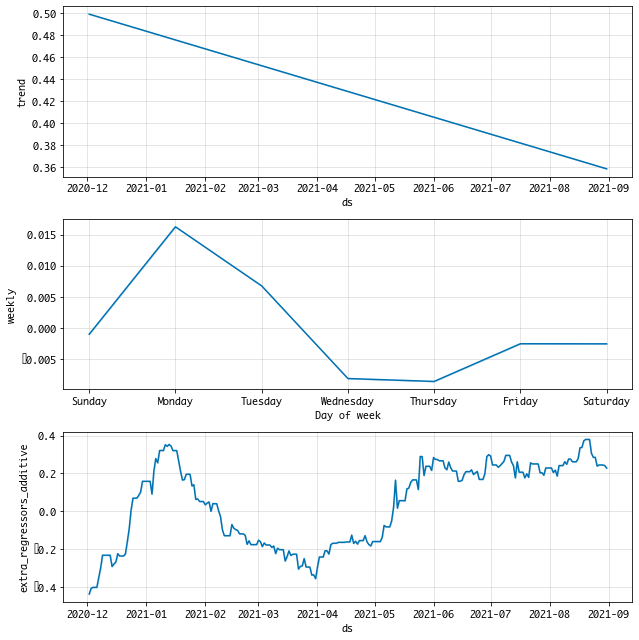

In [222]:
temp_prophet_df = pd.concat([train_y.rename('y'),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})

m = Prophet()
for col in temp_prophet_df.columns:
    if col not in ('y','ds'):
        m.add_regressor(col)

m.fit(temp_prophet_df)
future = m.make_future_dataframe(periods=len(test_x))

for col in temp_prophet_df.columns:
    if col not in ('y','ds'):
        df_aggresor = pd.concat([train_x[col], test_x[col]]).reset_index().drop('index',axis=1)
        future = pd.concat([future, df_aggresor],axis=1)

forecast = m.predict(future)
m.plot(forecast)
m.plot_components(forecast)

df_pred_xx9 = pd.DataFrame(forecast['yhat'][-50:]).rename(columns={0:'pred'})
mean_squared_error(df_pred_xx9['yhat'],df_test_xx['DELTA_CLOSE'], squared=False)

In [223]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,BOL_top3_SET100_corr,BOL_top3_SET100_corr_lower,BOL_top3_SET100_corr_upper,DELTA_VOLUME,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-02,0.499277,-0.028912,0.130184,0.499277,0.499277,0.086924,0.086924,0.086924,-0.003902,...,-0.437911,-0.437911,-0.437911,-0.008170,-0.008170,-0.008170,0.0,0.0,0.0,0.053196
1,2020-12-03,0.498760,-0.002934,0.157104,0.498760,0.498760,0.086924,0.086924,0.086924,0.003454,...,-0.408000,-0.408000,-0.408000,-0.008638,-0.008638,-0.008638,0.0,0.0,0.0,0.082122
2,2020-12-04,0.498242,0.009356,0.173780,0.498242,0.498242,0.091941,0.091941,0.091941,0.002584,...,-0.402331,-0.402331,-0.402331,-0.002571,-0.002571,-0.002571,0.0,0.0,0.0,0.093341
3,2020-12-06,0.497207,0.017295,0.169940,0.497207,0.497207,0.091941,0.091941,0.091941,0.002584,...,-0.402331,-0.402331,-0.402331,-0.001040,-0.001040,-0.001040,0.0,0.0,0.0,0.093836
4,2020-12-08,0.496172,0.127649,0.284121,0.496172,0.496172,0.094450,0.094450,0.094450,0.053913,...,-0.300041,-0.300041,-0.300041,0.006744,0.006744,0.006744,0.0,0.0,0.0,0.202874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2021-08-27,0.360564,0.521752,0.688143,0.360564,0.360564,-0.066102,-0.066102,-0.066102,-0.022924,...,0.244676,0.244676,0.244676,-0.002571,-0.002571,-0.002571,0.0,0.0,0.0,0.602669
246,2021-08-28,0.360046,0.521157,0.687278,0.360046,0.360046,-0.066102,-0.066102,-0.066102,-0.022924,...,0.244676,0.244676,0.244676,-0.002586,-0.002586,-0.002586,0.0,0.0,0.0,0.602136
247,2021-08-29,0.359529,0.523779,0.681444,0.359529,0.359529,-0.066102,-0.066102,-0.066102,-0.022924,...,0.244676,0.244676,0.244676,-0.001040,-0.001040,-0.001040,0.0,0.0,0.0,0.603164
248,2021-08-30,0.359011,0.543446,0.697149,0.359011,0.359011,-0.066102,-0.066102,-0.066102,-0.022924,...,0.241387,0.241387,0.241387,0.016261,0.016261,0.016261,0.0,0.0,0.0,0.616659


In [224]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


In [225]:
X = np.array(train_x)
train_x2 = X.reshape(X.shape[0],1,X.shape[1])
X2 = np.array(test_x)
test_x2 = X2.reshape(X2.shape[0],1,X2.shape[1])

# Instantiate LSTM
model = Sequential()

# Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
model.add(LSTM(20, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
# Dropout layer added to avoid overfit
model.add(Dropout(0.2))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
# model.add(LSTM(10, activation='relu', return_sequences=True))
# Add output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# epoch number times to run data in
model.fit(train_x2,train_y,epochs=10,batch_size=30)
# model.fit(train_x2,train_y,epochs=10,batch_size=40)
# model.fit(train_x2,train_y,epochs=5,batch_size=20)
pred_lstm = model.predict(test_x2)

# input is 3d so need to reshape
pred_lstm = pred_lstm.reshape(-1)

df_pred_xx10 = pd.DataFrame(pred_lstm).rename(columns={0:'pred'})
# df_pred_xx10
mean_squared_error(df_pred_xx10['pred'],df_test_xx['DELTA_CLOSE'], squared=False)

Epoch 1/10
7/7 [==============================] - 3s 2ms/step - loss: 0.2256
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2023
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1803
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1521
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1172
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0874
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0586
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0588
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0508
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0537


0.08224453102159308

<AxesSubplot:ylabel='pred'>

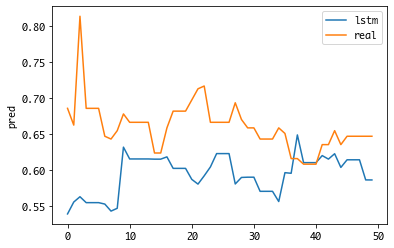

In [226]:
sns.lineplot(data=df_pred_xx10, x = df_pred_xx6.index, y='pred', label='lstm')
sns.lineplot(data=df_test_xx, x = df_test_xx.index, y='DELTA_CLOSE', label='real')

In [207]:
# For predicting the future case
# future_pred = min_max_scaler_inverse_transform(pd.concat([test_x,df_pred_xx10],axis=1), scaler)
# future_pred


,DELTA_VOLUME,METCO_ma50,SVI_LOW,DELTA_ma100,TEAM_rsi14,SVI_ma10,KCE_CLOSE,SMT_HIGH,DELTA_ema50,KCE_ema10,...,SVI_ema10,SVI_CLOSE,BOL_top3_SET100_corr,SVI_HIGH,KCE_HIGH,KCE_OPEN,KCE_VOLUME,HANA_VOLUME,NER_top3_SET100_corr,pred
0,857400.0,237.56,4.66,477.36,48.032333,4.902,81.50,6.30,553.943293,79.841830,...,4.889886,4.78,9.85,4.80,82.00,80.25,14222600.0,8002000.0,7.65,594.811383
1,1191900.0,237.52,4.74,479.61,49.875080,4.902,86.50,6.45,554.494537,81.052406,...,4.873543,4.80,9.60,4.82,88.50,82.00,36439000.0,17327900.0,7.55,645.674375
2,1291100.0,237.84,4.72,481.69,53.841102,4.890,85.75,6.50,554.318280,81.906514,...,4.852899,4.76,9.60,4.86,89.50,86.25,25768500.0,7533200.0,7.65,632.859145
3,796700.0,238.14,4.76,483.49,61.189936,4.886,86.75,6.50,554.148936,82.787148,...,4.846917,4.82,9.50,4.88,88.25,85.75,21843000.0,32687200.0,7.80,638.816913
4,845700.0,238.60,4.82,485.51,57.725873,4.878,86.75,6.45,553.829370,83.507666,...,4.849296,4.86,9.50,4.88,88.25,88.00,8730000.0,8969700.0,7.90,619.511905
5,845700.0,238.60,4.82,485.51,57.725873,4.878,86.75,6.45,553.829370,83.507666,...,4.849296,4.86,9.50,4.88,88.25,88.00,8730000.0,8969700.0,7.90,619.511905
6,845700.0,238.60,4.82,485.51,57.725873,4.878,86.75,6.45,553.829370,83.507666,...,4.849296,4.86,9.50,4.88,88.25,88.00,8730000.0,8969700.0,7.90,619.511905
7,992700.0,238.98,4.74,487.66,58.090880,4.858,82.50,6.35,554.071355,83.324454,...,4.840333,4.80,9.60,4.88,86.50,86.00,19586300.0,24720200.0,7.70,622.503536
8,676800.0,239.16,4.78,489.95,64.099616,4.848,81.25,6.25,554.303851,82.947281,...,4.840273,4.84,9.60,4.84,84.25,82.50,31333200.0,20412100.0,7.75,638.837481
9,1117400.0,239.46,4.78,492.44,70.438984,4.830,80.25,6.35,554.919386,82.456866,...,4.836587,4.82,9.60,4.84,81.75,81.25,22091400.0,23179000.0,7.65,621.636994


<AxesSubplot:ylabel='pred'>

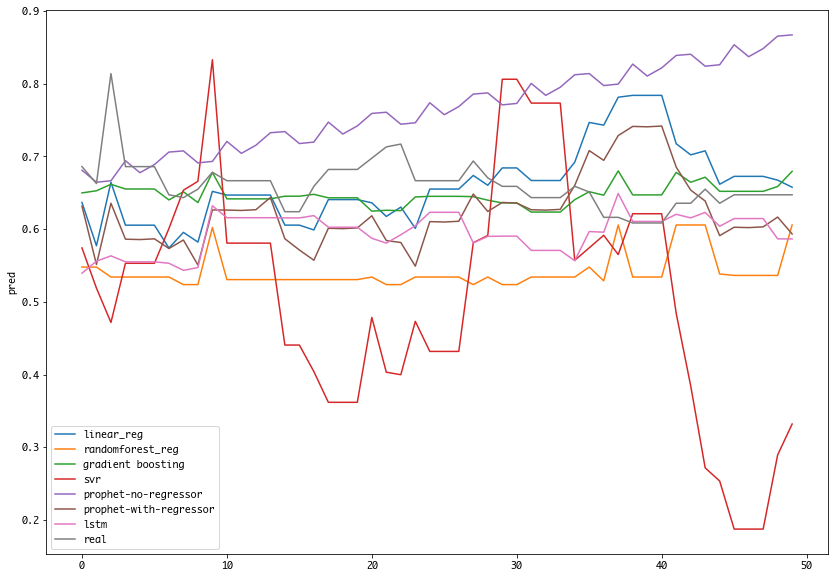

In [227]:

# sns.lineplot(pd.DataFrame(pred_reg), x = np.range(1,))
# sns.lineplot(y = list(test_y))
# list(test_y)
plt.figure(figsize=(14,10))

sns.lineplot(data=df_pred_xx, x = df_pred_xx.index, y='pred', label='linear_reg')
sns.lineplot(data=df_pred_xx2, x = df_pred_xx2.index, y='pred', label='randomforest_reg')
sns.lineplot(data=df_pred_xx5, x = df_pred_xx5.index, y='pred', label='gradient boosting')
sns.lineplot(data=df_pred_xx8, x = df_pred_xx6.index, y='pred', label='svr')
sns.lineplot(data=df_pred_xx7, x = df_pred_xx6.index, y='yhat', label='prophet-no-regressor')
sns.lineplot(data=df_pred_xx9, x = df_pred_xx6.index, y='yhat', label='prophet-with-regressor')
sns.lineplot(data=df_pred_xx10, x = df_pred_xx6.index, y='pred', label='lstm')

sns.lineplot(data=df_test_xx, x = df_test_xx.index, y='DELTA_CLOSE', label='real')



In [86]:
######### -> Cuyrrently need to fix the issue in get_sim_industry data if the data does not exist so should not return data

# get_all_sources_stock_data('gulf') # -> fail
# get_all_sources_stock_data('ADVANC') # -> fail
# get_all_sources_stock_data('kbank') # -> work
# get_all_sources_stock_data('SCB')  # -> work
# get_all_sources_stock_data('scc') # -> fail
# get_all_sources_stock_data('cpall') # -> work

In [87]:
def predict_stock_price_prophet():
    '''
    predict stockw ith prophet
    - here, input the data case we want to use and the train dataset, and then predict value output
    
    
    NOTE
    - here predict without aggressor
    - Create another one to predict with aggressor
    
    output
    - predicted values overtime, for the ones that we have
    - Shows the perforamnce error comparison with train and test for this case
    - predicted upper and lower band as well
    
    '''
    
    return 0

In [88]:
def create_predict_dataset_stock():
    '''
    Create dataset for prediction
    - To scope the data for latest data prediction
    
    ie from today, to predict 3m future, need 1y3m data backdate to fit model for prediction
    
    
    Takes in data stock from today latest
    Takes in granger causality shifts
    shifts the data
    then output array with different case
    - ie have 1, 2, 5, 12 granger causality -> then create thems eparately
    
    
    Input:
    dataframe
    
    Output
    dataframe
    
    '''
    
    
    
    return 0
    

## Model to use and algorithms
- Facebook prophet https://facebook.github.io/prophet/docs/quick_start.html
- - No aggressor
- - Add aggressor
- - - Compare performance
- 

LSTM
SVM
Auto ARIMA

### DATA train case
NOTE
- Need to checka nd use data to train and test proportion properly

Static case
- ie 202001 - 202103 train
- 202103 - 202106 test

Rolling case
- Rolling data overtime for training and testing model


#### Data functions finalisation
Show the flow of the functions to call and run for testing prediction 
- aggregate them all to one file